***Requirements***

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import holidays
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import entropy, gmean, hmean, trim_mean, shapiro, trimboth, kurtosis
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
import scipy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples
from collections import Counter
import pickle

***Data Loading***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***EDA***

In [ ]:
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
path ='/content/drive/MyDrive/mlproject/data-20250604T060844Z-1-001/data/'

def load_parquet(building_id):

    file_path = f"{path}{building_id}.parquet"
    return building_id, pd.read_parquet(file_path)

dfs = {}
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_parquet, i + 1) for i in range(1277)]
    for future in futures:
        try:
            building_id, df = future.result()
            dfs[f'df_{building_id}'] = df
        except Exception as e:
            print(f"Error loading a building file: {e}")

In [ ]:
dfs

{'df_1':                   timestamp  out.electricity.total.energy_consumption
 bldg_id                                                              
 1       2018-01-01 00:15:00                                     2.377
 1       2018-01-01 00:30:00                                     2.248
 1       2018-01-01 00:45:00                                     2.138
 1       2018-01-01 01:00:00                                     1.985
 1       2018-01-01 01:15:00                                     1.950
 ...                     ...                                       ...
 1       2018-12-31 23:00:00                                     0.836
 1       2018-12-31 23:15:00                                     0.789
 1       2018-12-31 23:30:00                                     0.795
 1       2018-12-31 23:45:00                                     0.796
 1       2019-01-01 00:00:00                                     0.800
 
 [35040 rows x 2 columns],
 'df_2':                   timestamp  ou

***Feature Extraction***

In [ ]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Unknown'

def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour <= 15:
        return 'Afternoon'
    elif 15 < hour <= 19:
        return 'Evening'
    else:
        return 'Night'

def get_day_type(day_of_week):
    if day_of_week < 5:
        return 'Weekday'
    else:
        return 'Weekend'

us_holidays = holidays.US()
us_holidays

def lagged_features(df, lag_period):
  df[f'lagby_{lag_period}'] = df['out.electricity.total.energy_consumption'].shift(lag_period)
  df['lag_diff'] = df['out.electricity.total.energy_consumption'] - df[f'lagby_{lag_period}']
  df['lag_%'] = (df['out.electricity.total.energy_consumption'] - df[f'lagby_{lag_period}'])*100 / df[f'lagby_{lag_period}']
  df['hourly_lag'] = df['out.electricity.total.energy_consumption'].shift(4)
  df['hourly_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['hourly_lag']
  df['daily_lag'] = df['out.electricity.total.energy_consumption'].shift(24 * 4)
  df['daily_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['daily_lag']
  df['monthly_lag'] = df['out.electricity.total.energy_consumption'].shift(24 * 30 * 4)
  df['monthly_lag_diff'] = df['out.electricity.total.energy_consumption'] - df['monthly_lag']
  return df

def moving_average(df, window_size):
  df['moving_average'] = df['out.electricity.total.energy_consumption'].rolling(window=window_size, min_periods=1).mean()
  return df
def moving_median(df, window_size):
  df['moving_median'] = df['out.electricity.total.energy_consumption'].rolling(window=window_size, min_periods=1).median()
  return df
def exponential_smoothing(df, alpha):
  df['smoothed_value'] = df['out.electricity.total.energy_consumption'].ewm(alpha=alpha).mean()
  return df


percentiles = [25, 50, 75, 90, 95 ,99, 100]
def calculate_percentiles(row, percentiles):
    return pd.Series(np.percentile(row, percentiles), index=[f'percentile_{p}' for p in percentiles])
percentile_columns = [f'percentile_{p}' for p in percentiles]


threshold_before_sunset = pd.to_datetime("17:00:00").time()
threshold_after_sunrise = pd.to_datetime("07:00:00").time()


In [ ]:
def extract_time_elements(df, lagged_window_size, alpha):
  new_row = pd.DataFrame({'timestamp': pd.to_datetime('2018-01-01 00:00:00'), 'out.electricity.total.energy_consumption': 0}, index = [0])
  df = pd.concat([new_row, df]).reset_index(drop=True)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['month'] = df['timestamp'].dt.month
  df['day_of_week'] = df['timestamp'].dt.dayofweek
  df['date'] = df['timestamp'].dt.day
  df['week_of_month'] = (df['date'] + 6) // 7
  df['hour'] = df['timestamp'].dt.hour
  df['Season'] = df['month'].apply(get_season)
  df['TimeOfDay'] = df['hour'].apply(get_time_of_day)
  df['weekday/end'] = df['day_of_week'].apply(get_day_type)
  df['IsHoliday'] = df['timestamp'].apply(lambda x: 1 if x in us_holidays else 0)
  df = lagged_features(df, lagged_window_size)
  df = moving_average(df, lagged_window_size)
  df = moving_median(df, lagged_window_size)
  df = exponential_smoothing(df, alpha)
  max_values = df.groupby(['month', 'date'], as_index = False)['out.electricity.total.energy_consumption'].max()
  df = pd.merge(df, max_values, on=['month', 'date'], suffixes=('', '_max_day'))
  df = df.sort_values(by='timestamp')
  skew_values = df.groupby(['month', 'week_of_month'], as_index = False)['out.electricity.total.energy_consumption'].skew()
  df = pd.merge(df, skew_values, on=['month', 'week_of_month'], suffixes=('', '_skew_day'))
  kurto_values = df.groupby(['month', 'week_of_month'], as_index = False)['out.electricity.total.energy_consumption'].apply(pd.Series.kurtosis)
  df = pd.merge(df, kurto_values, on=['month', 'week_of_month'], suffixes=('', '_kurto_day'))
  return df


In [ ]:
df_1 = dfs['df_1']
df_1 =  extract_time_elements(df_1, 1, 0.2)
df_1.head()

timestamp  out.electricity.total.energy_consumption  month  \
0 2018-01-01 00:00:00                                     0.000      1   
1 2018-01-01 00:15:00                                     2.377      1   
2 2018-01-01 00:30:00                                     2.248      1   
3 2018-01-01 00:45:00                                     2.138      1   
4 2018-01-01 01:00:00                                     1.985      1   

   day_of_week  date  week_of_month  hour  Season TimeOfDay weekday/end  ...  \
0            0     1              1     0  Winter     Night     Weekday  ...   
1            0     1              1     0  Winter     Night     Weekday  ...   
2            0     1              1     0  Winter     Night     Weekday  ...   
3            0     1              1     0  Winter     Night     Weekday  ...   
4            0     1              1     1  Winter     Night     Weekday  ...   

   daily_lag  daily_lag_diff  monthly_lag  monthly_lag_diff  moving_average  \
0        NaN             NaN          NaN               NaN           0.000   
1        NaN             NaN          NaN               NaN           2.377   
2        NaN             NaN          NaN               NaN           2.248   
3        NaN             NaN          NaN               NaN           2.138   
4        NaN             NaN          NaN               NaN           1.985   

   moving_median  smoothed_value  \
0          0.000        0.000000   
1          2.377        1.320556   
2          2.248        1.700656   
3          2.138        1.848808   
4          1.985        1.889322   

   out.electricity.total.energy_consumption_max_day  \
0                                             2.988   
1                                             2.988   
2                                             2.988   
3                                             2.988   
4                                             2.988   

   out.electricity.total.energy_consumption_skew_day  \
0                                           0.385077   
1                                           0.385077   
2                                           0.385077   
3                                           0.385077   
4                                           0.385077   

   out.electricity.total.energy_consumption_kurto_day  
0                                           0.443182   
1                                           0.443182   
2                                           0.443182   
3                                           0.443182   
4                                           0.443182   

[5 rows x 26 columns]

In [ ]:
features_df = pd.DataFrame()
for i in range(1277):
    j = i + 1
    df = dfs['df_'+ str(j)]
    df_1 = extract_time_elements(df, 1, 0.2)
    df_holi_timeofday = df_1.groupby(['IsHoliday','TimeOfDay'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_holi_month = df_1.groupby(['IsHoliday','month'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_holi_hour = df_1.groupby(['IsHoliday','hour'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_timeofdsay = df_1.groupby(['weekday/end', 'TimeOfDay'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_month = df_1.groupby(['weekday/end', 'month'], as_index = False)['out.electricity.total.energy_consumption'].median()
    df_weekend_hour = df_1.groupby(['weekday/end', 'hour'], as_index = False)['out.electricity.total.energy_consumption'].median()
    percentiles = [25, 50, 75, 95, 100]
    moving_avg_percen = np.percentile(df_1['moving_average'], percentiles)
    moving_median_percen = np.percentile(df_1['moving_median'], percentiles)
    exposmooth_percen = np.percentile(df_1['smoothed_value'], percentiles)
    lagdiff_percen = np.percentile(df_1['lag_%'][2:], percentiles)
    winter_percentiles = np.percentile(df_1[df_1['Season'] == 'Winter']['out.electricity.total.energy_consumption'], percentiles)
    summer_percentiles = np.percentile(df_1[df_1['Season'] == 'Summer']['out.electricity.total.energy_consumption'], percentiles)
    autumn_percentiles = np.percentile(df_1[df_1['Season'] == 'Autumn']['out.electricity.total.energy_consumption'], percentiles)
    spring_percentiles = np.percentile(df_1[df_1['Season'] == 'Spring']['out.electricity.total.energy_consumption'], percentiles)
    night_df = df_1[df_1['TimeOfDay'] == 'Night']
    morning_df = df_1[df_1['TimeOfDay'] == 'Morning']
    evening_df = df_1[df_1['TimeOfDay'] == 'Evening']
    afternoon_df = df_1[df_1['TimeOfDay'] == 'Afternoon']
    summer_df = df_1[df_1['Season'] == 'Summer']
    winter_df = df_1[df_1['Season'] == 'Winter']
    spring_df = df_1[df_1['Season'] == 'Spring']
    autumn_df = df_1[df_1['Season'] == 'Autumn']
    hourly_consumption = df_1.groupby('hour')['out.electricity.total.energy_consumption'].sum()
    timeofday_consumption = df_1.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    monthly_consumption = df_1.groupby('month')['out.electricity.total.energy_consumption'].sum()
    summer_hourly_sum = summer_df.groupby(summer_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    winter_hourly_sum = winter_df.groupby(winter_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    spring_hourly_sum = spring_df.groupby(spring_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    autumn_hourly_sum = autumn_df.groupby(autumn_df['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].sum()
    daily_sum = df.groupby(df['timestamp'].dt.date)['out.electricity.total.energy_consumption'].sum()

    working_hrs = df_1[(df_1['hour'] >= 9) & (df_1['hour'] <= 17)]
    working_hrs_hourly = working_hrs.groupby(['month', 'date','hour'], as_index = False)['out.electricity.total.energy_consumption'].sum()
    working_hrs_hourly_max = working_hrs_hourly['out.electricity.total.energy_consumption'].max()
    working_hrs_hourly_min = working_hrs_hourly['out.electricity.total.energy_consumption'].min()

    summer_time_of_day_consumption = summer_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    winter_time_of_day_consumption = winter_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    spring_time_of_day_consumption = spring_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    autumn_time_of_day_consumption = autumn_df.groupby('TimeOfDay')['out.electricity.total.energy_consumption'].sum()
    percentiles_1 = [10, 25, 50, 75, 90, 95, 100]
    consumption_percentiles = np.percentile(df_1['out.electricity.total.energy_consumption'], percentiles_1)
    hourly_percen = np.percentile(df_1.groupby(['month','date','hour'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    daily_percen = np.percentile(df_1.groupby(['month','date'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    weekly_percen = np.percentile(df_1.groupby(['month','week_of_month'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    monthly_percen = np.percentile(df_1.groupby(['month','month'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    night_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Night'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    evening_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Evening'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    afternoon_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Afternoon'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)
    morning_percen = np.percentile(df_1[df_1['TimeOfDay'] == 'Morning'].groupby(['month','date','TimeOfDay'])['out.electricity.total.energy_consumption'].sum(), percentiles_1)


    one_row = pd.DataFrame({
                        'ID': j,
                        'Total_cons': [df_1['out.electricity.total.energy_consumption'].sum()],
                        'Avg_cons': [df_1['out.electricity.total.energy_consumption'].mean()],
                        'Median_cons': [df_1['out.electricity.total.energy_consumption'].median()],
                        'weekday_sum': [df_1.groupby(['weekday/end'])['out.electricity.total.energy_consumption'].sum()[0]],
                        'weekend_sum': [df_1.groupby(['weekday/end'])['out.electricity.total.energy_consumption'].sum()[1]],
                        'weekday_peak': [df_1[df_1['weekday/end'] == 'Weekend'].groupby(['month','date','weekday/end'])['out.electricity.total.energy_consumption'].sum().max()],
                        'weekend_peak': [df_1[df_1['weekday/end'] == 'Weekday'].groupby(['month','date','weekday/end'])['out.electricity.total.energy_consumption'].sum().max()],
                        'which_season_peak': [df_1.groupby(['Season'])['out.electricity.total.energy_consumption'].sum().idxmax()],
                        'peak_season_cons': [df_1.groupby(['Season'])['out.electricity.total.energy_consumption'].sum().max()],
                        'which_week_peak': [df_1.groupby(['week_of_month'])['out.electricity.total.energy_consumption'].median().idxmax()],
                        'peak_week_cons': [df_1.groupby(['week_of_month'])['out.electricity.total.energy_consumption'].median().max()],
                        'which_day_of_week_peak': [df_1.groupby(['day_of_week'])['out.electricity.total.energy_consumption'].sum().idxmax()],
                        'peak_day_of_week_cons': [df_1.groupby(['day_of_week'])['out.electricity.total.energy_consumption'].sum().max()],
                        'which_hour_peak': [df_1.groupby(['hour'])['out.electricity.total.energy_consumption'].sum().idxmax()],
                        'peak_hour_cons': [df_1.groupby(['hour'])['out.electricity.total.energy_consumption'].sum().max()],
                        'weekend_timeofday_max': [df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekend']['out.electricity.total.energy_consumption'].max()],
                        'weekend_timeofday':df_weekend_timeofdsay.loc[df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekend'][['out.electricity.total.energy_consumption']].idxmax()]['TimeOfDay'].values[0],
                        'weekday_timeofday_max': [df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekday']['out.electricity.total.energy_consumption'].max()],
                        'weekday_timeofday':df_weekend_timeofdsay.loc[df_weekend_timeofdsay[df_weekend_timeofdsay['weekday/end'] == 'Weekday'][['out.electricity.total.energy_consumption']].idxmax()]['TimeOfDay'].values[0],
                        'weekend_hour_max': [df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekend']['out.electricity.total.energy_consumption'].max()],
                        'weekend_hour':df_weekend_hour.loc[df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekend'][['out.electricity.total.energy_consumption']].idxmax()]['hour'].values[0],
                        'weekday_hour_max': [df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekday']['out.electricity.total.energy_consumption'].max()],
                        'weekday_hour':df_weekend_hour.loc[df_weekend_hour[df_weekend_hour['weekday/end'] == 'Weekday'][['out.electricity.total.energy_consumption']].idxmax()]['hour'].values[0],
                        'night_cons': night_df['out.electricity.total.energy_consumption'].sum(),
                        'morning_cons': morning_df['out.electricity.total.energy_consumption'].sum(),
                        'evening_cons': evening_df['out.electricity.total.energy_consumption'].sum(),
                        'afternoon_cons': afternoon_df['out.electricity.total.energy_consumption'].sum(),
                        'peak_hour': hourly_consumption.idxmax(),
                        'peak_TimeOfDay': timeofday_consumption.idxmax(),
                        'peak_day': daily_sum.idxmax(),
                        'peak_month': monthly_consumption.idxmax(),
                        'summer_peak_hour': summer_hourly_sum.idxmax(),
                        'winter_peak_hour': winter_hourly_sum.idxmax(),
                        'spring_peak_hour': spring_hourly_sum.idxmax(),
                        'autumn_peak_hour': autumn_hourly_sum.idxmax(),
                        'summer_max_consumption_TimeOfDay': summer_time_of_day_consumption.idxmax(),
                        'summer_max_consumption_value': summer_time_of_day_consumption.max(),
                        'winter_max_consumption_TimeOfDay': winter_time_of_day_consumption.idxmax(),
                        'winter_max_consumption_value': winter_time_of_day_consumption.max(),
                        'spring_max_consumption_TimeOfDay': spring_time_of_day_consumption.idxmax(),
                        'spring_max_consumption_value': spring_time_of_day_consumption.max(),
                        'autumn_max_consumption_TimeOfDay': autumn_time_of_day_consumption.idxmax(),
                        'autumn_max_consumption_value': autumn_time_of_day_consumption.max(),
                        'summer_weekday_consumption': summer_df[summer_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'summer_weekend_consumption': summer_df[summer_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'winter_weekday_consumption': winter_df[winter_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'winter_weekend_consumption': winter_df[winter_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'spring_weekday_consumption': spring_df[spring_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'spring_weekend_consumption': spring_df[spring_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'autumn_weekday_consumption': autumn_df[autumn_df['timestamp'].dt.dayofweek < 5]['out.electricity.total.energy_consumption'].sum(),
                        'autumn_weekend_consumption': autumn_df[autumn_df['timestamp'].dt.dayofweek >= 5]['out.electricity.total.energy_consumption'].sum(),
                        'Working_hrs_cons': working_hrs['out.electricity.total.energy_consumption'].sum(),
                        'working_hrs_peak_15min' : working_hrs['out.electricity.total.energy_consumption'].max(),
                        'working_hrs_valley_15min' : working_hrs['out.electricity.total.energy_consumption'].min(),
                        'working_hrs_peak_hrly' : working_hrs_hourly_max,
                        'working_hrs_valley_hrly' : working_hrs_hourly_min,
                        'which_working_hrs_peak_hrly' : working_hrs_hourly[working_hrs_hourly['out.electricity.total.energy_consumption'] == working_hrs_hourly_max]['hour'].values[0],
                        'which_working_hrs_valley_hrly' : working_hrs_hourly[working_hrs_hourly['out.electricity.total.energy_consumption'] == working_hrs_hourly_min]['hour'].values[0],

                        'cons_10': consumption_percentiles[0],'cons_25': consumption_percentiles[1],'cons_50': consumption_percentiles[2],'cons_75': consumption_percentiles[3],'cons_90': consumption_percentiles[4],'cons_95': consumption_percentiles[5],'cons_100': consumption_percentiles[6],
                        'range': (df_1['out.electricity.total.energy_consumption'].max() - df_1['out.electricity.total.energy_consumption'].min()),
                        'hourly_range': ((df_1.groupby(['hour'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'daily_range': ((df_1.groupby(['date'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'weekly_range': ((df_1.groupby(['week_of_month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'day_of_week_range': ((df_1.groupby(['day_of_week'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'monthly_range': ((df_1.groupby(['month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().apply(lambda x: x.max() - x.min()))[1]),
                        'monthly_avg' : (df_1.groupby(['month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'weekly_avg' : (df_1.groupby(['month', 'week_of_month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'daily_avg' : (df_1.groupby(['month', 'week_of_month', 'day_of_week'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'hourly_avg' : (df_1.groupby(['month', 'week_of_month', 'day_of_week', 'hour'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
                        'hourly_median': (df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].median()).median(),
                        'daily_median': (df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].median()).median(),
                        'weekly_median': (df_1.resample('W', on='timestamp')['out.electricity.total.energy_consumption'].median()).median(),
                        'monthly_median': (df_1.groupby('month')['out.electricity.total.energy_consumption'].median()).median(),
                        'max-percentile_95': df_1['out.electricity.total.energy_consumption'].max() - np.percentile(df_1['out.electricity.total.energy_consumption'], 95),
                        'hourly_max/median': df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'daily_max/median': df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'weekly_max/median': df_1.groupby(df_1['timestamp'].dt.isocalendar().week)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'monthly_max/median': df_1.groupby(df_1['timestamp'].dt.month)['out.electricity.total.energy_consumption'].apply(lambda x: x.max() / x.median()).median(),
                        'hourly_skewness':(df_1.groupby(df_1['timestamp'].dt.hour)['out.electricity.total.energy_consumption'].skew()).median(),
                        'daily_skewness': (df_1.groupby(df_1['timestamp'].dt.date)['out.electricity.total.energy_consumption'].skew()).median(),
                        'weekly_skewness': (df_1.groupby(df_1['timestamp'].dt.isocalendar().week)['out.electricity.total.energy_consumption'].skew()).median(),
                        'monthly_skewness': (df_1.groupby(df_1['timestamp'].dt.month)['out.electricity.total.energy_consumption'].skew()).median(),
                        'kurtosis': kurtosis(df_1['out.electricity.total.energy_consumption'].dropna()),
                        'std': np.std(df_1['out.electricity.total.energy_consumption']),
                        'entropy':entropy(df_1['out.electricity.total.energy_consumption']),
                        'p99-p1/p50': (np.percentile(df_1['out.electricity.total.energy_consumption'], 99) - np.percentile(df_1['out.electricity.total.energy_consumption'], 1))/np.percentile(df_1['out.electricity.total.energy_consumption'], 50),
                        'geometric_mean': gmean(df_1[df_1['out.electricity.total.energy_consumption'] != 0]['out.electricity.total.energy_consumption']),
                        'trimmed_mean': trim_mean(df_1['out.electricity.total.energy_consumption'], proportiontocut=0.1),
                        'mean_abs_dev': np.mean(np.abs(df_1['out.electricity.total.energy_consumption'] - np.mean(df_1['out.electricity.total.energy_consumption']))),
                        'median_abs_dev': np.median(np.abs(df_1['out.electricity.total.energy_consumption'] - np.median(df_1['out.electricity.total.energy_consumption']))),
                        'mean/peak': df_1['out.electricity.total.energy_consumption'].mean()/df_1['out.electricity.total.energy_consumption'].max(),
                        'trimmed_range': trimboth(df_1['out.electricity.total.energy_consumption'], 0.1).max() - trimboth(df_1['out.electricity.total.energy_consumption'], 0.1).min(),
                        'hourly_10': hourly_percen[0],'hourly_25': hourly_percen[1],'hourly_50': hourly_percen[2],'hourly_75': hourly_percen[3],'hourly_90': hourly_percen[4], 'hourly_95': hourly_percen[5], 'hourly_100': hourly_percen[6],
                        'daily_10': daily_percen[0],'daily_25': daily_percen[1],'daily_50': daily_percen[2],'daily_75': daily_percen[3],'daily_90': daily_percen[4],'daily_95': daily_percen[5],'daily_100': daily_percen[6],
                        'weekly_10': weekly_percen[0],'weekly_25': weekly_percen[1],'weekly_50': weekly_percen[2],'weekly_75': weekly_percen[3],'weekly_90': weekly_percen[4],'weekly_95': weekly_percen[5],'weekly_100': weekly_percen[6],
                        'monthly_10': monthly_percen[0],'monthly_25': monthly_percen[1],'monthly_50': monthly_percen[2],'monthly_75': monthly_percen[3],'monthly_90': monthly_percen[4],'monthly_95': monthly_percen[5],'monthly_100': monthly_percen[6],
                        'night_10': night_percen[0],'night_25': night_percen[1],'night_50': night_percen[2],'night_75': night_percen[3],'night_90': night_percen[4],'night_95': night_percen[5],'night_100': night_percen[6],
                        'evening_10': evening_percen[0],'evening_25': evening_percen[1],'evening_50': evening_percen[2],'evening_75': evening_percen[3],'evening_90': evening_percen[4],'evening_95': evening_percen[5],'evening_100': evening_percen[6],
                        'afternoon_10': afternoon_percen[0],'afternoon_25': afternoon_percen[1],'afternoon_50': afternoon_percen[2],'afternoon_75': afternoon_percen[3],'afternoon_90': afternoon_percen[4],'afternoon_95': afternoon_percen[5],'afternoon_100': afternoon_percen[6],
                        'morning_10': morning_percen[0],'morning_25': morning_percen[1],'morning_50': morning_percen[2],'morning_75': morning_percen[3],'morning_90': morning_percen[4],'morning_95': morning_percen[5],'morning_100': morning_percen[6],
                        'moving_mean_25': moving_avg_percen[0],'moving_mean_50': moving_avg_percen[1],'moving_mean_75': moving_avg_percen[2],'moving_mean_95': moving_avg_percen[3],'moving_mean_100': moving_avg_percen[4],
                        'moving_median_25': moving_median_percen[0],'moving_median_50': moving_median_percen[1],'moving_median_75': moving_median_percen[2],'moving_median_95': moving_median_percen[3],'moving_median_100': moving_median_percen[4],
                        'expo_25': exposmooth_percen[0],'expo_50': exposmooth_percen[1],'expo_75': exposmooth_percen[2],'expo_95': exposmooth_percen[3],'expo_100': exposmooth_percen[4],
                        'lag_25': lagdiff_percen[0],'lag_50': lagdiff_percen[1],'lag_75': lagdiff_percen[2],'lag_95': lagdiff_percen[3],'lag_100': lagdiff_percen[4],
                        'winter_25': winter_percentiles[0],'winter_50': winter_percentiles[1],'winter_75': winter_percentiles[2],'winter_100': winter_percentiles[4],
                        'summer_25': summer_percentiles[0],'summer_50': summer_percentiles[1],'summer_75': summer_percentiles[2],'summer_100': summer_percentiles[4],
                        'autumn_25': autumn_percentiles[0],'autumn_50': autumn_percentiles[1],'autumn_75': autumn_percentiles[2],'autumn_100': autumn_percentiles[4],
                        'spring_25': spring_percentiles[0],'spring_50': spring_percentiles[1],'spring_75': spring_percentiles[2],'spring_100': spring_percentiles[4]
  })
    features_df = pd.concat([features_df, one_row], axis=0)

features_df

Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-11-3243707212.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'weekly_avg' : (df_1.groupby(['month', 'week_of_month'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
/tmp/ipython-input-11-3243707212.py:129: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'daily_avg' : (df_1.groupby(['month', 'week_of_month', 'day_of_week'], as_index = False)[['out.electricity.total.energy_consumption']].sum().median()[1]),
/tmp/ipython-input-11-3243707212.py:130: FutureWarning: Series.__getitem__ treating keys as positions i

ID    Total_cons    Avg_cons  Median_cons   weekday_sum   weekend_sum  \
0      1  2.408795e+04    0.687422     0.612000  1.733177e+04  6.756178e+03   
0      2  2.460349e+03    0.070213     0.062000  1.783170e+03  6.771790e+02   
0      3  9.449000e+02    0.026966     0.015000  7.161900e+02  2.287100e+02   
0      4  1.056136e+04    0.301400     0.184000  7.535563e+03  3.025798e+03   
0      5  1.779647e+04    0.507876     0.433000  1.268043e+04  5.116044e+03   
..   ...           ...         ...          ...           ...           ...   
0   1273  1.394102e+06   39.784880    36.488494  1.037882e+06  3.562201e+05   
0   1274  5.970104e+05   17.037481    12.842887  4.968181e+05  1.001922e+05   
0   1275  1.477677e+06   42.169955    38.636934  9.011545e+05  5.765229e+05   
0   1276  6.229248e+05   17.777028    16.620970  4.991760e+05  1.237489e+05   
0   1277  1.072432e+07  306.050735   256.050915  7.871301e+06  2.853023e+06   

    weekday_peak  weekend_peak which_season_peak  peak_season_cons  ...  \
0     257.774000    221.336000            Winter      9.085557e+03  ...   
0      19.423000     13.422000            Summer      7.816870e+02  ...   
0      12.322000     17.196000            Summer      4.281980e+02  ...   
0      40.797000     51.434000            Winter      2.872404e+03  ...   
0     181.737000    189.635000            Winter      6.434691e+03  ...   
..           ...           ...               ...               ...  ...   
0    7277.668914   6990.547375            Summer      3.630764e+05  ...   
0    2247.836140   2891.166915            Summer      1.875802e+05  ...   
0   10158.871683   7755.368585            Winter      4.011725e+05  ...   
0    2172.985796   2892.709559            Summer      1.977833e+05  ...   
0   30664.987686  30643.802153            Summer      2.725124e+06  ...   

     summer_75  summer_100   autumn_25   autumn_50   autumn_75  autumn_100  \
0     0.602000    1.925000    0.384000    0.531000    0.703000    2.239000   
0     0.107000    0.277000    0.032000    0.045000    0.071000    0.270000   
0     0.055000    0.468000    0.012000    0.013000    0.018000    0.389000   
0     0.322000    2.225000    0.117000    0.168000    0.336000    2.092000   
0     0.470000    3.208000    0.262000    0.370000    0.498250    2.841000   
..         ...         ...         ...         ...         ...         ...   
0    61.395439   88.720806   20.789397   35.305677   56.421268   96.744687   
0    32.694782   54.441134   10.404975   12.626356   22.239976   53.170768   
0    72.696763   98.224560   13.398386   35.653728   67.504279   95.831424   
0    30.866470   47.628650    8.775716   14.955000   23.650081   44.860672   
0   348.497772  540.694257  237.212687  256.020687  344.185609  536.456934   

     spring_25   spring_50   spring_75  spring_100  
0     0.463000    0.608000    0.754000    2.622000  
0     0.037000    0.044000    0.068000    0.290000  
0     0.013000    0.015000    0.022000    0.130000  
0     0.114000    0.168000    0.353250    2.073000  
0     0.312750    0.434000    0.576000    2.837000  
..         ...         ...         ...         ...  
0    20.844043   35.187687   56.723294   87.843725  
0    10.494835   11.811969   21.353025   44.203620  
0    12.712875   36.169227   68.806628   97.623894  
0     8.159914   13.130467   21.100970   39.523013  
0   236.130505  256.513145  341.995176  539.561520  

[1277 rows x 191 columns]

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(


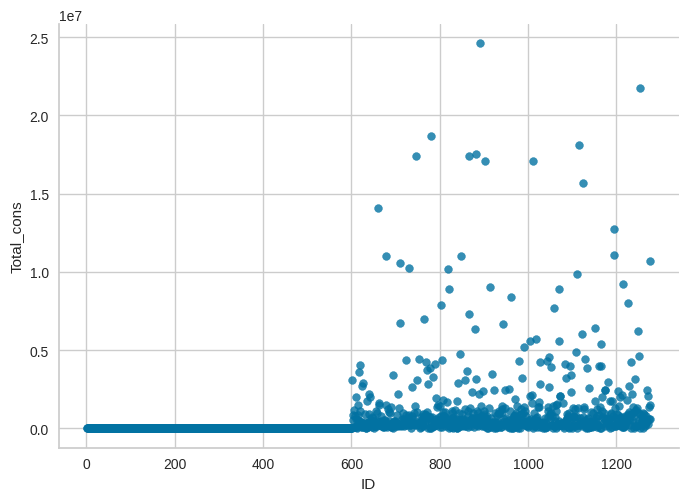

In [ ]:
from matplotlib import pyplot as plt
features_df.plot(kind='scatter', x='ID', y='Total_cons', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
for i in range(1277):
    j = i + 1
    df = dfs['df_'+ str(j)]
    if len(df[df['out.electricity.total.energy_consumption'] <= 0]) > 0:
      print('Rows with negative consumption of building ID', j ,' is', len(df[df['out.electricity.total.energy_consumption'] <= 0]))

Rows with negative consumption of building ID 963  is 39


In [ ]:
df = dfs['df_963']
df[df['out.electricity.total.energy_consumption'] <= 0].head(5)

timestamp  out.electricity.total.energy_consumption
bldg_id                                                              
963     2018-03-19 06:15:00                                 -0.180833
963     2018-03-19 21:15:00                                 -0.201497
963     2018-03-19 21:30:00                                 -0.413133
963     2018-03-19 21:45:00                                 -0.803168
963     2018-03-19 22:00:00                                 -0.899525

/tmp/ipython-input-15-3130246350.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resample('H').mean().reset_index()
/tmp/ipython-input-15-3130246350.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resample('H').mean().reset_index()
/tmp/ipython-input-15-3130246350.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resample('H').mean().reset_index()
/tmp/ipython-input-15-3130246350.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resample('H').mean().reset_index()
/tmp/ipython-input-15-3130246350.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('timestamp').resam

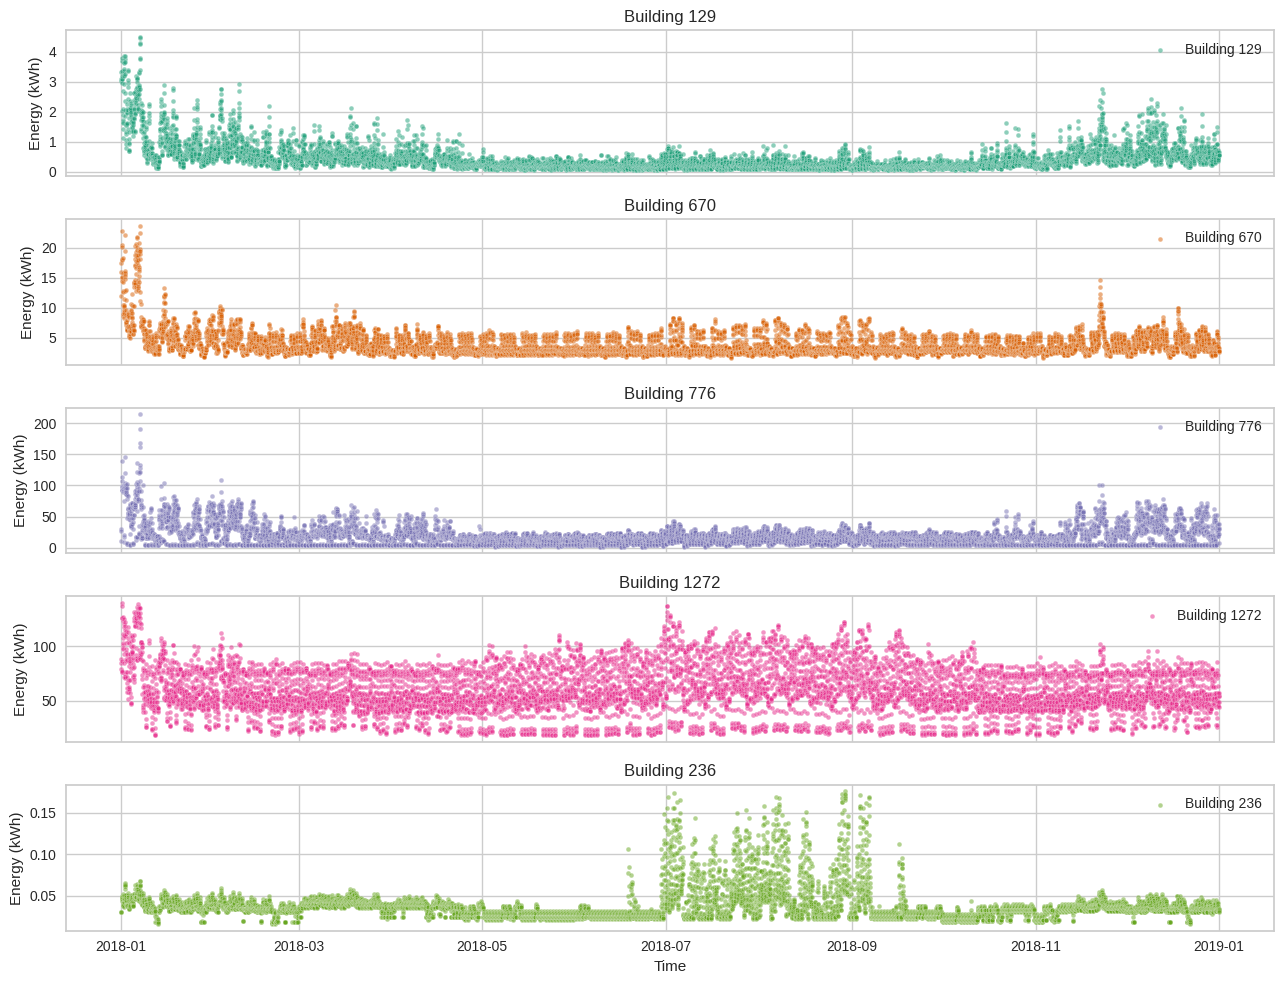

In [ ]:
import random
path = '/content/drive/MyDrive/mlproject/data-20250604T060844Z-1-001/data/'
col = 'out.electricity.total.energy_consumption'
all_building_ids = [i for i in range(1, 1278)]

sample_buildings = random.sample(all_building_ids, 5)

colors = sns.color_palette("Dark2", n_colors=5)

fig, axes = plt.subplots(5, 1, figsize=(13, 10), sharex=True)

for i, b in enumerate(sample_buildings):
    try:
        df = pd.read_parquet(f"{path}{b}.parquet")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp').resample('H').mean().reset_index()

        sns.scatterplot(data=df, x='timestamp', y=col, ax=axes[i],
                        s=12, alpha=0.5, color=colors[i], label=f'Building {b}')
        axes[i].set_title(f'Building {b}')
        axes[i].set_ylabel('Energy (kWh)')
        axes[i].legend()
    except Exception as e:
        axes[i].set_title(f'Error loading Building {b}: {e}')
        axes[i].axis('off')

plt.xlabel('Time')
plt.tight_layout()
plt.show()

100%|██████████| 1277/1277 [01:04<00:00, 19.93it/s]


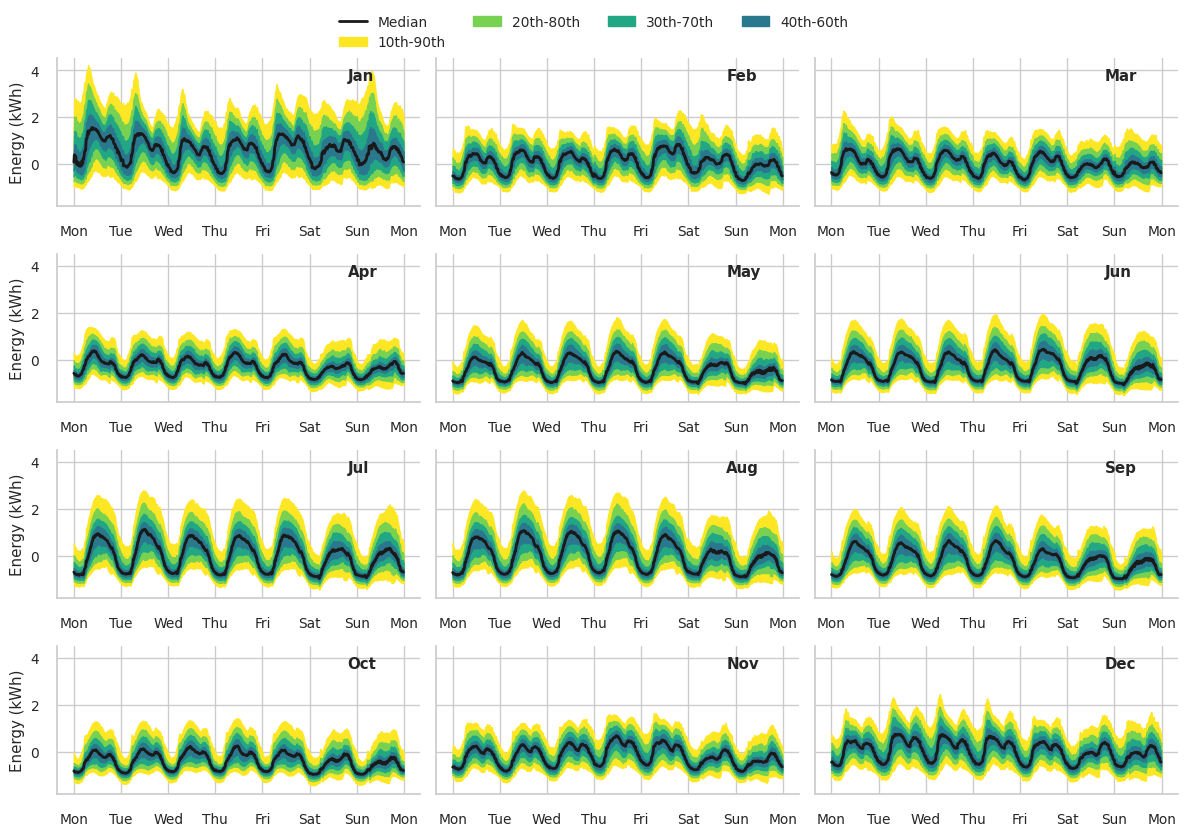

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

path = '/content/drive/MyDrive/mlproject/data-20250604T060844Z-1-001/data/'
TARGET_COL = 'out.electricity.total.energy_consumption'
MONTH_NAMES = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
WEEKDAY_NAMES = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

building_data = []

for b in tqdm(range(1, 1278)):
    try:
        df = pd.read_parquet(f"{path}{b}.parquet")
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.set_index('timestamp').resample('15min').mean().reset_index()
        df = df[['timestamp', TARGET_COL]].dropna()
        if df.empty:
            continue
        building_data.append(df)
    except Exception as e:
        print(f"Skipping building {b}: {e}")

temporal_features = []

for df in building_data:
    dt = df.timestamp.dt
    df['month'] = dt.month
    df['time_of_week'] = (dt.dayofweek * 96) + (dt.hour * 4) + (dt.minute // 15)

    x = df.groupby(['month', 'time_of_week'])[TARGET_COL].mean().values
    if len(x) == 12 * 7 * 96:
        normalized = (x - np.mean(x)) / np.std(x)
        temporal_features.append(normalized)
temporal_features = np.array(temporal_features)
weekly_average = temporal_features.reshape((len(temporal_features), -1, 7 * 96)).mean(1)
df = pd.DataFrame(dict(
    month_name=np.repeat([x[:3] for x in MONTH_NAMES], 7 * 96),
    time_of_week=np.tile(range(7 * 96), 12),
    value_mean=temporal_features.mean(0),
    value_10=np.quantile(temporal_features, 0.1, 0),
    value_20=np.quantile(temporal_features, 0.2, 0),
    value_30=np.quantile(temporal_features, 0.3, 0),
    value_40=np.quantile(temporal_features, 0.4, 0),
    value_50=np.quantile(temporal_features, 0.5, 0),
    value_60=np.quantile(temporal_features, 0.6, 0),
    value_70=np.quantile(temporal_features, 0.7, 0),
    value_80=np.quantile(temporal_features, 0.8, 0),
    value_90=np.quantile(temporal_features, 0.9, 0),
))

sns.set(style='whitegrid', font_scale=0.9)
g = sns.relplot(
    data=df,
    x='time_of_week', y='value_50', col='month_name', color='k', legend=False, label='Median',
    estimator=None, kind='line', linewidth=2, zorder=5, col_wrap=3, height=2, aspect=2.0,
)
for month, ax in g.axes_dict.items():
    tmp = df[df.month_name == month]
    ax.fill_between(tmp.time_of_week, tmp.value_10, tmp.value_90, alpha=1.0, color='#fde724', label='10th-90th')
    ax.fill_between(tmp.time_of_week, tmp.value_20, tmp.value_80, alpha=1.0, color='#79d151', label='20th-80th')
    ax.fill_between(tmp.time_of_week, tmp.value_30, tmp.value_70, alpha=1.0, color='#22a784', label='30th-70th')
    ax.fill_between(tmp.time_of_week, tmp.value_40, tmp.value_60, alpha=1.0, color='#29788e', label='40th-60th')
    ax.text(.8, .85, month, transform=ax.transAxes, fontweight='bold')
    ax.set_xticks(96 * np.arange(8), [WEEKDAY_NAMES[i % 7][:3] for i in np.arange(8)])
    ax.xaxis.set_tick_params(labelbottom=True)
g.fig.subplots_adjust(hspace=0.2, wspace=0.1)
g.set_axis_labels('', 'Energy (kWh)')
g.set_titles('')
handles, labels = g.axes_dict[list(g.axes_dict.keys())[0]].get_legend_handles_labels()
g.fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout()
plt.show()

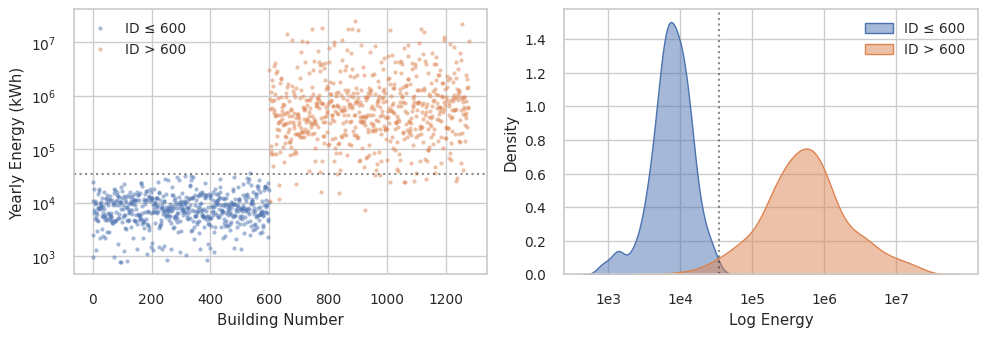

In [ ]:
energy = np.array([df[TARGET_COL].sum() for df in building_data])

plt.figure(figsize=(10, 3.5))

plt.subplot(1, 2, 1)
plt.semilogy(energy[:600], '.', label='ID ≤ 600', alpha=0.5)
plt.semilogy(range(600, 1277), energy[600:], '.', label='ID > 600', alpha=0.5)
plt.axhline(35000, ls=':', color='k', alpha=0.5)
plt.xlabel('Building Number')
plt.ylabel('Yearly Energy (kWh)')
plt.legend()

plt.subplot(1, 2, 2)
sns.kdeplot(np.log10(energy[:600]), fill=True, label='ID ≤ 600', alpha=0.5)
sns.kdeplot(np.log10(energy[600:]), fill=True, label='ID > 600', alpha=0.5)
plt.axvline(np.log10(35000), ls=':', color='k', alpha=0.5)
plt.xticks(range(3, 8), [f'1e{x}' for x in range(3, 8)])
plt.xlabel('Log Energy')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

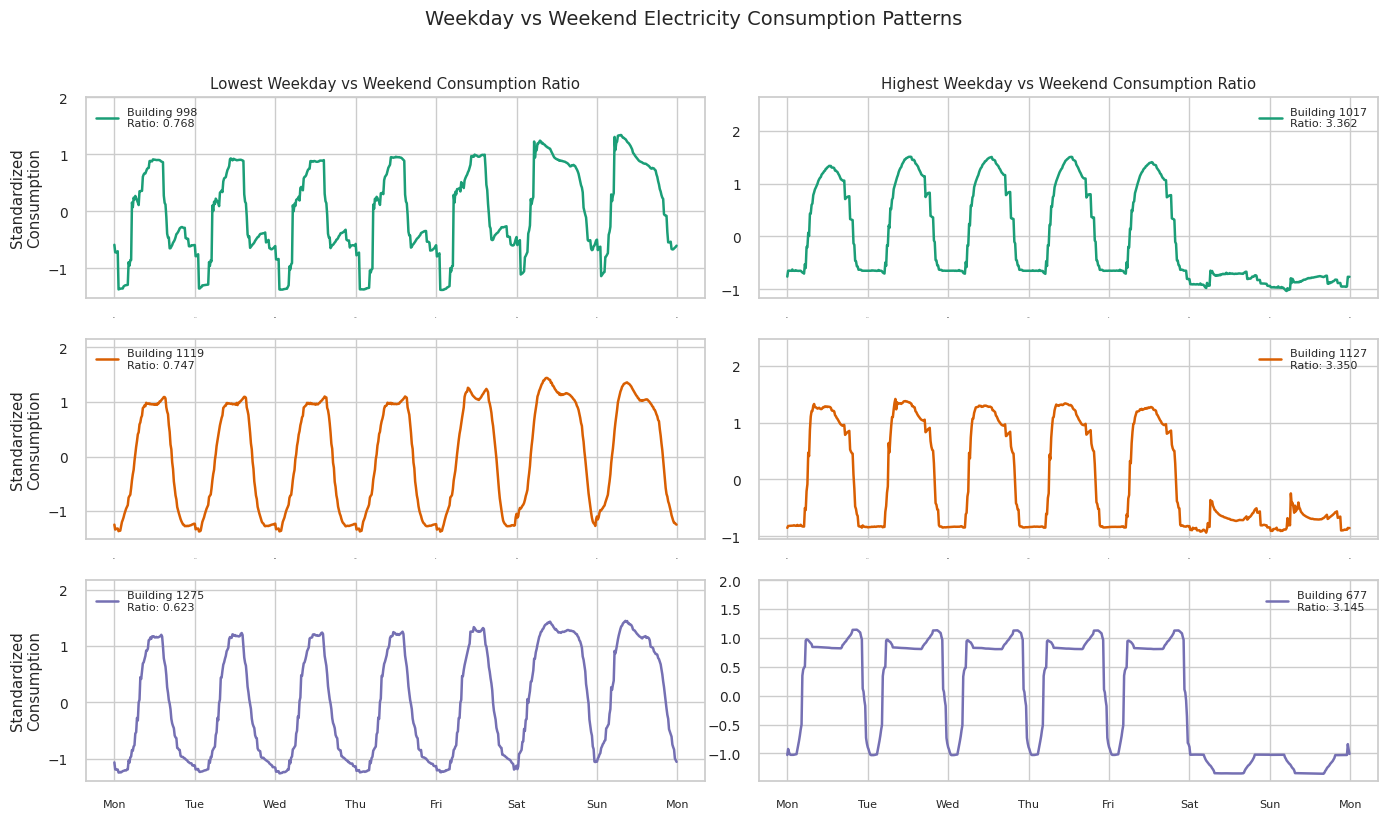

In [ ]:
weekday_weekend_consumption_ratio = []
for df in building_data:
    x = df.groupby('time_of_week')[TARGET_COL].mean().values
    weekday_avg = x[:96*5].mean()
    weekend_avg = x[96*5:].mean()
    weekday_weekend_consumption_ratio.append(weekday_avg / weekend_avg)

weekday_weekend_consumption_ratio = np.array(weekday_weekend_consumption_ratio)
plt.figure(figsize=(14, 8))
colors = ['#1b9e77', '#d95f02', '#7570b3']
for i, building_num in enumerate(np.argsort(weekday_weekend_consumption_ratio)[:3][::-1]):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(weekly_average[building_num], color=colors[i], linewidth=1.8,
             label=f'Building {building_num + 1}\nRatio: {weekday_weekend_consumption_ratio[building_num]:.3f}')
    plt.ylim(None, 1.5 * weekly_average[building_num].max())
    plt.ylabel('Standardized\nConsumption')
    plt.legend(loc='upper left', fontsize=8)
    if i == 0:
        plt.title('Lowest Weekday vs Weekend Consumption Ratio')
    plt.xticks(
        ticks=np.linspace(0, 672, 8),
        labels=[WEEKDAY_NAMES[j % 7][:3] for j in range(8)],
        fontsize=8 if i == 2 else 0
    )
for i, building_num in enumerate(np.argsort(-weekday_weekend_consumption_ratio)[:3]):
    plt.subplot(3, 2, 2*i+2)
    plt.plot(weekly_average[building_num], color=colors[i], linewidth=1.8,
             label=f'Building {building_num + 1}\nRatio: {weekday_weekend_consumption_ratio[building_num]:.3f}')
    plt.ylim(None, 1.75 * weekly_average[building_num].max())
    plt.legend(loc='upper right', fontsize=8)
    if i == 0:
        plt.title('Highest Weekday vs Weekend Consumption Ratio')
    plt.xticks(
        ticks=np.linspace(0, 672, 8),
        labels=[WEEKDAY_NAMES[j % 7][:3] for j in range(8)],
        fontsize=8 if i == 2 else 0
    )
plt.suptitle('Weekday vs Weekend Electricity Consumption Patterns', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

***K-Means Clustering***

In [ ]:
features_df_copy = features_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]

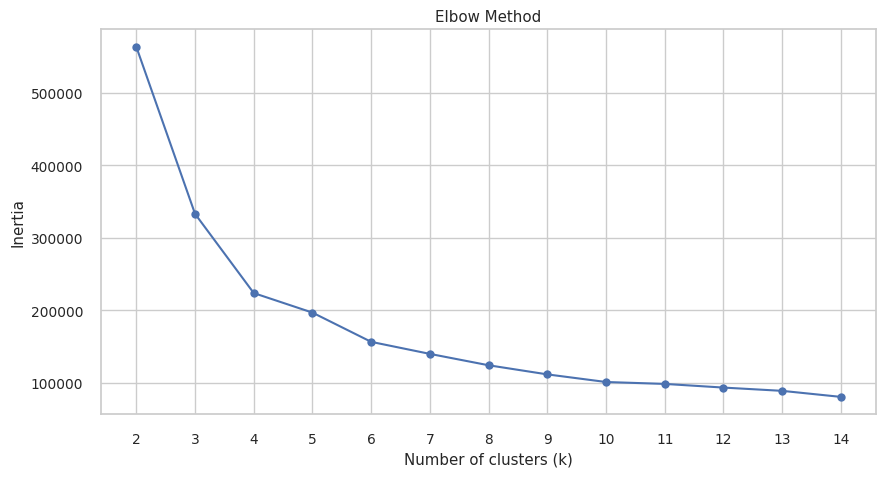

In [ ]:
k_values = range(2, 15)
inertia_values = []
silhouette_scores = []
features_df_copy = features_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]


rbst_scaler = RobustScaler()
features_df_copy = rbst_scaler.fit_transform(features_df_copy)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_df_copy)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_df_copy, kmeans.labels_))
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

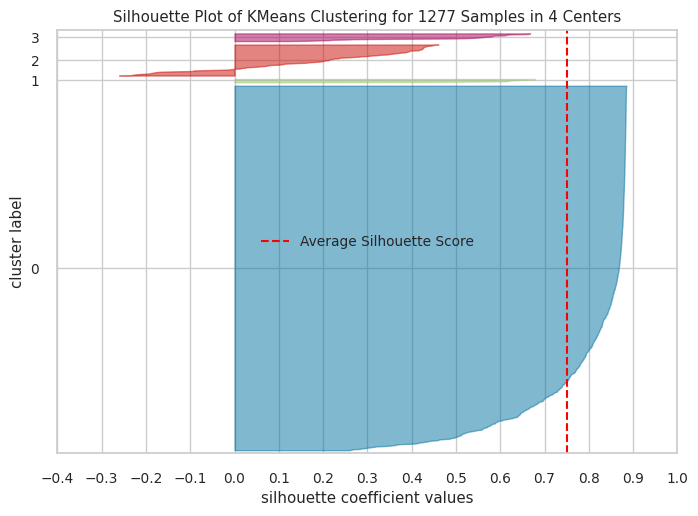

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1277 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(4, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(features_df_copy)
visualizer.show()

In [ ]:
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(features_df_copy)

with open('kmeans_model_1.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

with open('kmeans_model_1.pkl', 'rb') as file:
    kmeans = pickle.load(file)

cluster_labels = kmeans.labels_
features_df['Cluster'] = cluster_labels


silhouette_avg = silhouette_score(features_df_copy, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

features_df.head()


Silhouette Score: 0.7510


ID  Total_cons  Avg_cons  Median_cons  weekday_sum  weekend_sum  \
0   1   24087.947  0.687422        0.612    17331.769     6756.178   
0   2    2460.349  0.070213        0.062     1783.170      677.179   
0   3     944.900  0.026966        0.015      716.190      228.710   
0   4   10561.361  0.301400        0.184     7535.563     3025.798   
0   5   17796.474  0.507876        0.433    12680.430     5116.044   

   weekday_peak  weekend_peak which_season_peak  peak_season_cons  ...  \
0       257.774       221.336            Winter          9085.557  ...   
0        19.423        13.422            Summer           781.687  ...   
0        12.322        17.196            Summer           428.198  ...   
0        40.797        51.434            Winter          2872.404  ...   
0       181.737       189.635            Winter          6434.691  ...   

   summer_100  autumn_25  autumn_50  autumn_75  autumn_100  spring_25  \
0       1.925      0.384      0.531    0.70300       2.239    0.46300   
0       0.277      0.032      0.045    0.07100       0.270    0.03700   
0       0.468      0.012      0.013    0.01800       0.389    0.01300   
0       2.225      0.117      0.168    0.33600       2.092    0.11400   
0       3.208      0.262      0.370    0.49825       2.841    0.31275   

   spring_50 spring_75  spring_100 Cluster  
0      0.608   0.75400       2.622       0  
0      0.044   0.06800       0.290       0  
0      0.015   0.02200       0.130       0  
0      0.168   0.35325       2.073       0  
0      0.434   0.57600       2.837       0  

[5 rows x 192 columns]

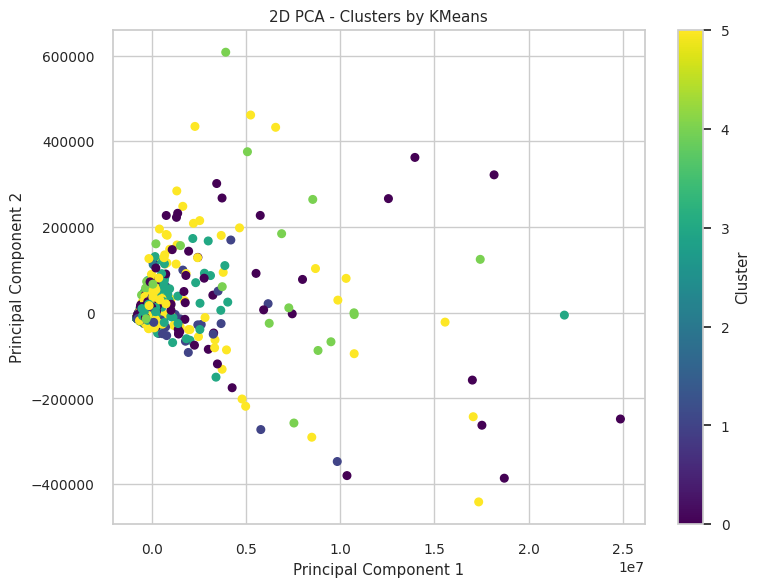

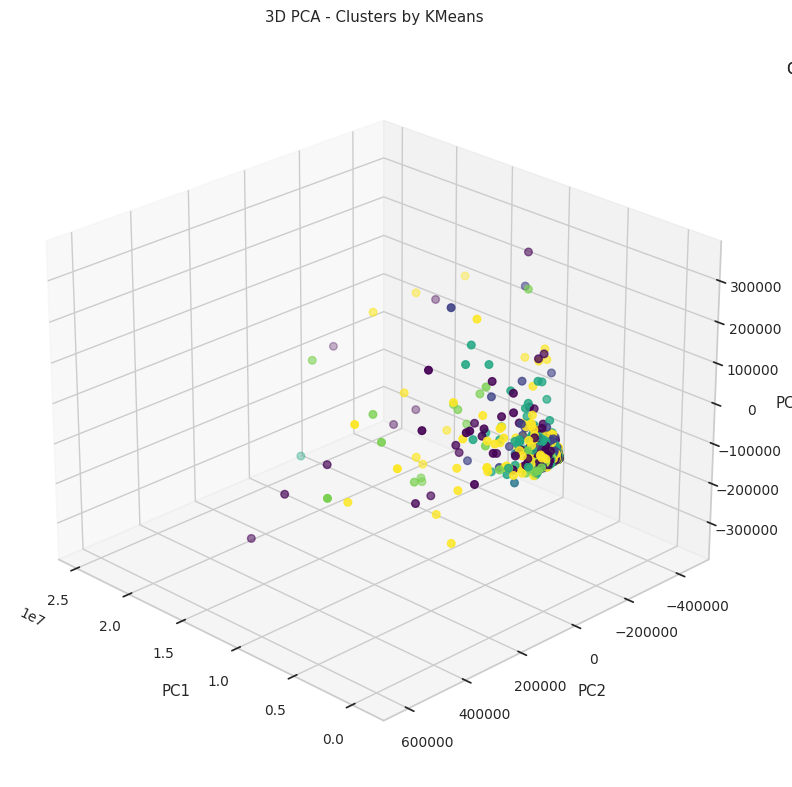

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(features_df_copy)
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.title('2D PCA - Clusters by KMeans')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(features_df_copy)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2],
                     c=cluster_labels, cmap='viridis', s=30)
ax.set_title('3D PCA - Clusters by KMeans')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


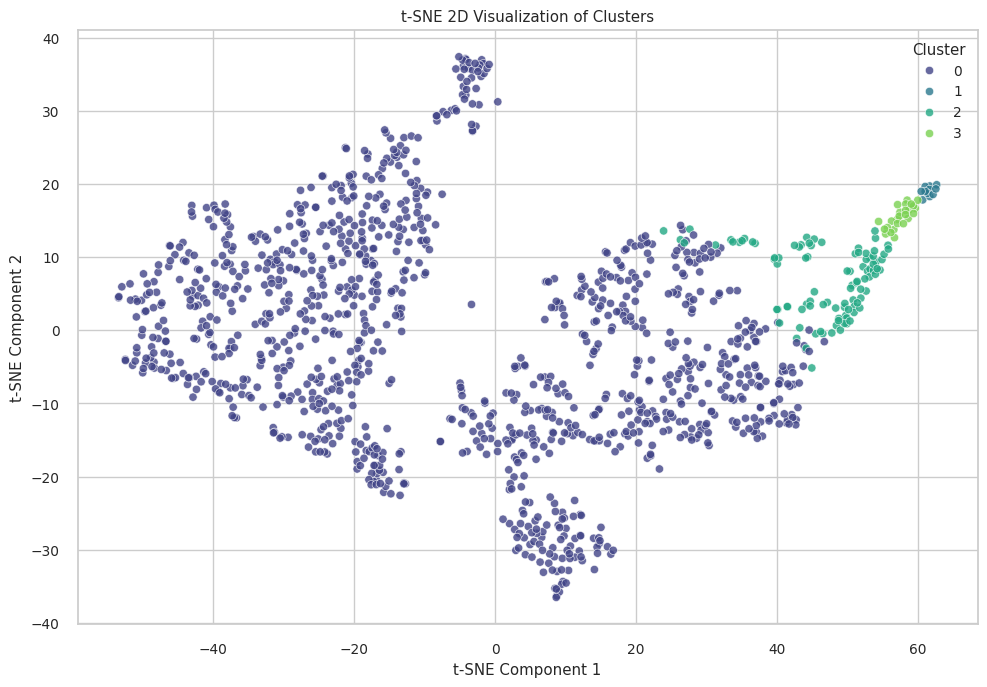

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_result = tsne.fit_transform(features_df_copy)


tsne_df = pd.DataFrame()
tsne_df['TSNE-1'] = tsne_result[:, 0]
tsne_df['TSNE-2'] = tsne_result[:, 1]
tsne_df['Cluster'] = cluster_labels
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='TSNE-1', y='TSNE-2',
    hue='Cluster',
    palette=sns.color_palette('viridis', len(set(cluster_labels))),
    data=tsne_df,
    legend='full',
    alpha=0.8
)
plt.title('t-SNE 2D Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()

***DBSCAN Clustering***

In [ ]:
!pip install kneed

Best epsilon value: 22.685694902332898


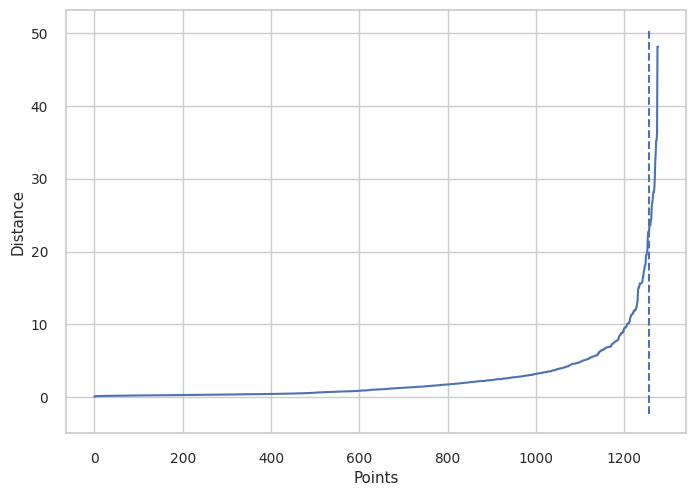

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

nearest_neighbors = NearestNeighbors(n_neighbors=2)
distances, indices = nearest_neighbors.fit(features_df_copy).kneighbors(features_df_copy)

distances = np.sort(distances, axis=0)
plt.plot(distances[:, 1])
plt.xlabel('Points')
plt.ylabel('Distance')

from kneed import KneeLocator
knee = KneeLocator(range(len(distances)), distances[:, 1], curve='convex', direction='increasing')
best_eps = distances[knee.elbow, 1]
print("Best epsilon value:", best_eps)

plt.vlines(knee.elbow, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import pandas as pd

silhouette_scores = []
min_samples_range = range(2, 10)

for min_samples in min_samples_range:
    dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(features_df_copy)

    if len(set(cluster_labels)) <= 1:
        silhouette_scores.append(float('nan'))
    else:
        score = silhouette_score(features_df_copy, cluster_labels)
        silhouette_scores.append(score)

df_output = pd.DataFrame({
    'min_samples': list(min_samples_range),
    'silhouette_score': silhouette_scores
})

df_output

min_samples  silhouette_score
0            2          0.702599
1            3          0.704724
2            4          0.848453
3            5          0.862095
4            6          0.849093
5            7          0.865058
6            8          0.866571
7            9          0.866318

In [ ]:
dbscan = DBSCAN(eps=22.685694902332738, min_samples=4)
dbscan.fit(features_df_copy)

with open('dbscan_model.pkl', 'wb') as file:
    pickle.dump(dbscan, file)

with open('dbscan_model.pkl', 'rb') as file:
    dbscan = pickle.load(file)

cluster_labels = dbscan.labels_

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")


Estimated number of clusters: 2
Estimated number of noise points: 27


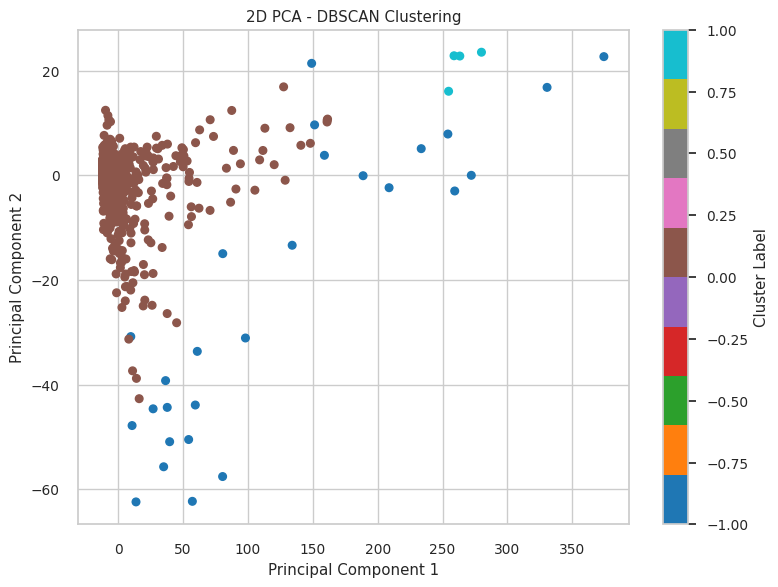

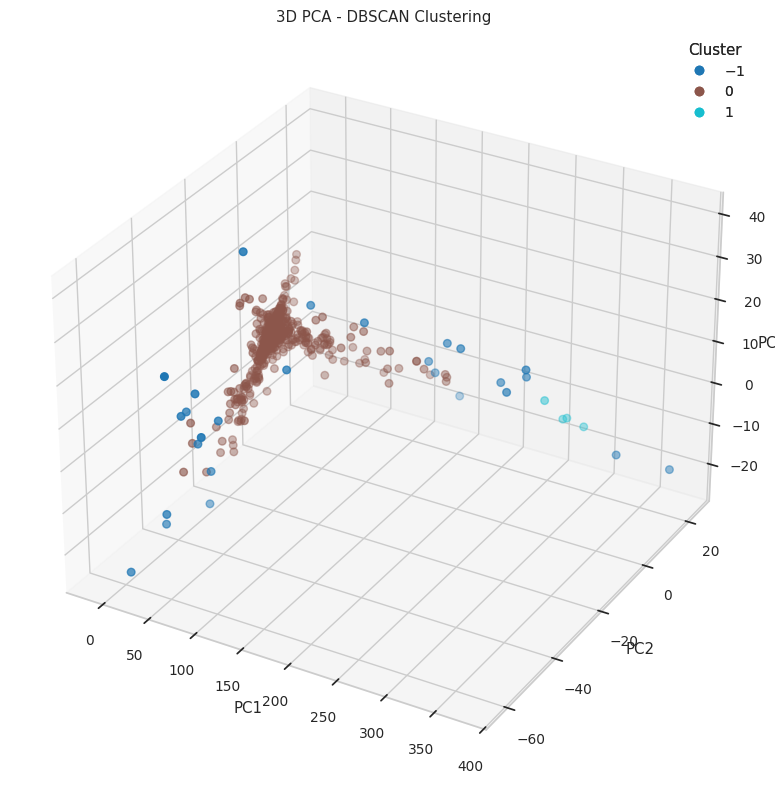

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(features_df_copy)
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=cluster_labels, cmap='tab10', s=30)
plt.title('2D PCA - DBSCAN Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(features_df_copy)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2],
                     c=cluster_labels, cmap='tab10', s=30)
ax.set_title('3D PCA - DBSCAN Clustering')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()


***Clustering of cluster 0***

In [ ]:
cluster_0_df = features_df[features_df['Cluster'] == 0]

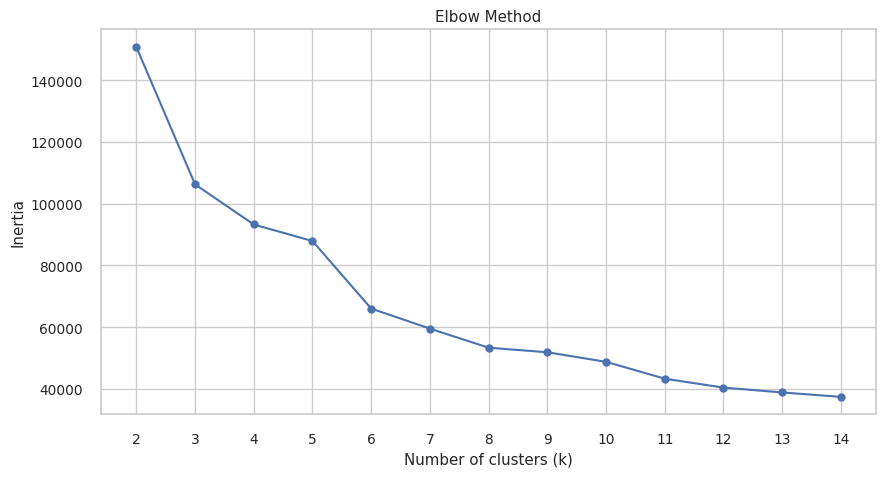

In [ ]:
k_values = range(2, 15)
inertia_values = []
silhouette_scores = []

final_df_copy = cluster_0_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]



rbst_scaler = RobustScaler()
final_df_copy = rbst_scaler.fit_transform(final_df_copy)

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df_copy)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(final_df_copy, kmeans.labels_))
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

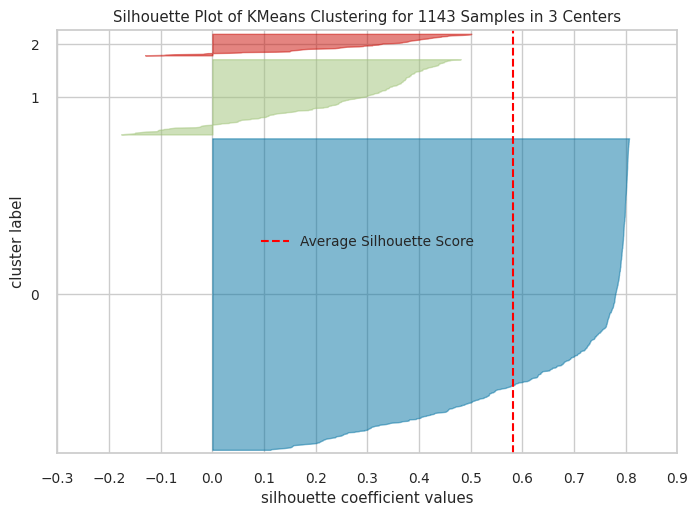

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1143 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(final_df_copy)
visualizer.show()

In [ ]:
final_df_copy = cluster_0_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]


rbst_scaler = RobustScaler()
final_df_copy = rbst_scaler.fit_transform(final_df_copy)
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(final_df_copy)
with open('kmeans_model_2.pkl', 'wb') as file:
    pickle.dump(kmeans, file)
cluster_label = kmeans.labels_
cluster_0_df['Cluster'] = kmeans.labels_
silhouette_avg = silhouette_score(final_df_copy, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")
cluster_0_df.head()

Silhouette Score: 0.5817348969652544


/tmp/ipython-input-33-4095755873.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_df['Cluster'] = kmeans.labels_


ID  Total_cons  Avg_cons  Median_cons  weekday_sum  weekend_sum  \
0   1   24087.947  0.687422        0.612    17331.769     6756.178   
0   2    2460.349  0.070213        0.062     1783.170      677.179   
0   3     944.900  0.026966        0.015      716.190      228.710   
0   4   10561.361  0.301400        0.184     7535.563     3025.798   
0   5   17796.474  0.507876        0.433    12680.430     5116.044   

   weekday_peak  weekend_peak which_season_peak  peak_season_cons  ...  \
0       257.774       221.336            Winter          9085.557  ...   
0        19.423        13.422            Summer           781.687  ...   
0        12.322        17.196            Summer           428.198  ...   
0        40.797        51.434            Winter          2872.404  ...   
0       181.737       189.635            Winter          6434.691  ...   

   summer_100  autumn_25  autumn_50  autumn_75  autumn_100  spring_25  \
0       1.925      0.384      0.531    0.70300       2.239    0.46300   
0       0.277      0.032      0.045    0.07100       0.270    0.03700   
0       0.468      0.012      0.013    0.01800       0.389    0.01300   
0       2.225      0.117      0.168    0.33600       2.092    0.11400   
0       3.208      0.262      0.370    0.49825       2.841    0.31275   

   spring_50 spring_75  spring_100 Cluster  
0      0.608   0.75400       2.622       0  
0      0.044   0.06800       0.290       0  
0      0.015   0.02200       0.130       0  
0      0.168   0.35325       2.073       0  
0      0.434   0.57600       2.837       0  

[5 rows x 192 columns]

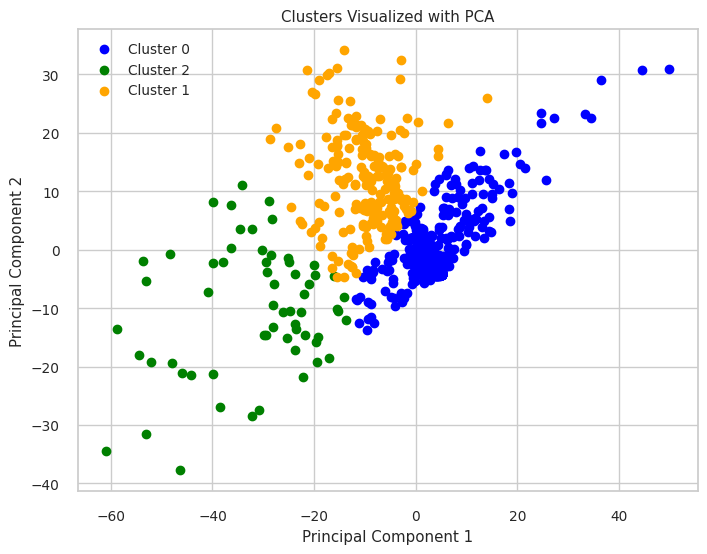

In [ ]:
pca = PCA(n_components=2)
pca.fit(final_df_copy)
df_pca = pca.transform(final_df_copy)
plt.figure(figsize=(8, 6))
colors = ['blue','green', 'orange']
cluster_labels = cluster_0_df['Cluster'].unique()
for i, cluster_label in enumerate(cluster_labels):

    cluster_data = df_pca[cluster_0_df['Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_label}', color=colors[i])
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

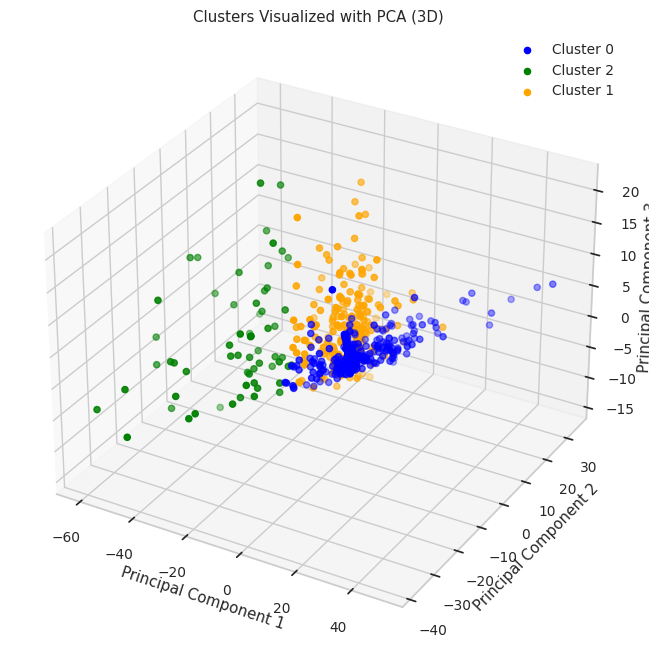

In [ ]:
pca = PCA(n_components=3)
pca.fit(final_df_copy)
df_pca = pca.transform(final_df_copy)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['blue', 'green', 'orange']
cluster_labels = cluster_0_df['Cluster'].unique()
for i, cluster_label in enumerate(cluster_labels):
    cluster_data = df_pca[cluster_0_df['Cluster'] == cluster_label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], label=f'Cluster {cluster_label}', color=colors[i])
ax.set_title('Clusters Visualized with PCA (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [ ]:
pd.DataFrame(cluster_0_df['Cluster'].value_counts()).reset_index()

Cluster  count
0        0    871
1        1    211
2        2     61

In [ ]:
final_remaining = features_df[features_df['Cluster'] != 0]
cluster_0_df['Cluster'] = cluster_0_df['Cluster'].replace({0: '0a', 1: '0b', 2: '0c'})
clustered_data = pd.concat([final_remaining, cluster_0_df], axis=0)
clustered_data['Cluster'] = clustered_data['Cluster'].astype(str)
label_encoder = LabelEncoder()
clustered_data['Cluster_encoded'] = label_encoder.fit_transform(clustered_data['Cluster'])
clustered_data.sort_values(by = 'ID').head()

/tmp/ipython-input-37-418979855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_0_df['Cluster'] = cluster_0_df['Cluster'].replace({0: '0a', 1: '0b', 2: '0c'})


ID  Total_cons  Avg_cons  Median_cons  weekday_sum  weekend_sum  \
0   1   24087.947  0.687422        0.612    17331.769     6756.178   
0   2    2460.349  0.070213        0.062     1783.170      677.179   
0   3     944.900  0.026966        0.015      716.190      228.710   
0   4   10561.361  0.301400        0.184     7535.563     3025.798   
0   5   17796.474  0.507876        0.433    12680.430     5116.044   

   weekday_peak  weekend_peak which_season_peak  peak_season_cons  ...  \
0       257.774       221.336            Winter          9085.557  ...   
0        19.423        13.422            Summer           781.687  ...   
0        12.322        17.196            Summer           428.198  ...   
0        40.797        51.434            Winter          2872.404  ...   
0       181.737       189.635            Winter          6434.691  ...   

   autumn_25  autumn_50  autumn_75  autumn_100  spring_25  spring_50  \
0      0.384      0.531    0.70300       2.239    0.46300      0.608   
0      0.032      0.045    0.07100       0.270    0.03700      0.044   
0      0.012      0.013    0.01800       0.389    0.01300      0.015   
0      0.117      0.168    0.33600       2.092    0.11400      0.168   
0      0.262      0.370    0.49825       2.841    0.31275      0.434   

   spring_75 spring_100  Cluster Cluster_encoded  
0    0.75400      2.622       0a               0  
0    0.06800      0.290       0a               0  
0    0.02200      0.130       0a               0  
0    0.35325      2.073       0a               0  
0    0.57600      2.837       0a               0  

[5 rows x 193 columns]

/tmp/ipython-input-38-407909863.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Cluster'] = temp_df['Cluster']


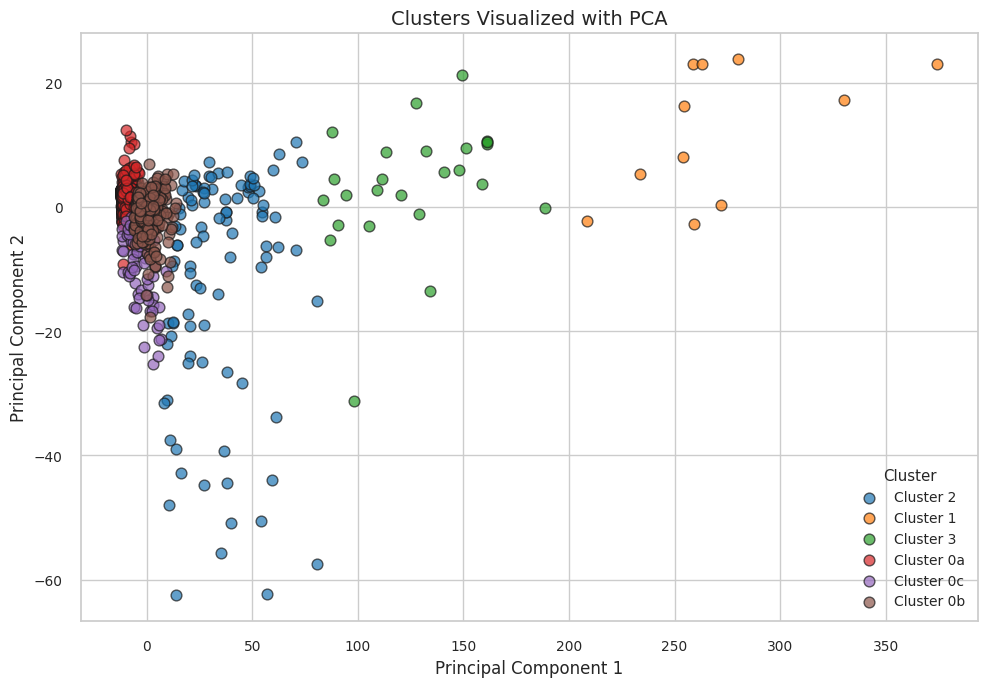

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
rbst_scaler = RobustScaler()
result_df = clustered_data[['Total_cons','Avg_cons','Median_cons','std',
                            'moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100',
                            'moving_median_25','moving_median_50','moving_median_75','moving_median_95','moving_median_100',
                            'expo_25','expo_50','expo_75','expo_95','expo_100',
                            'lag_25','lag_50','lag_75','lag_95','lag_100',
                            'winter_25','winter_50','winter_75','winter_100',
                            'summer_25','summer_50','summer_75','summer_100',
                            'autumn_25','autumn_50','autumn_75','autumn_100',
                            'spring_25','spring_50','spring_75','spring_100',
                            'p99-p1/p50','trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range',
                            'hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range',
                            'monthly_avg','weekly_avg','daily_avg','hourly_avg',
                            'cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100',
                            'hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                            'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100',
                            'weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100',
                            'monthly_10','monthly_25','monthly_50','monthly_75','monthly_90','monthly_95','monthly_100',
                            'Cluster_encoded']]
temp_df = clustered_data[['Cluster']]
result_scaled = rbst_scaler.fit_transform(result_df)
pca = PCA(n_components=2)
df_pca = pca.fit_transform(result_scaled)
result_df['Cluster'] = temp_df['Cluster']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(10, 7))
cluster_labels = result_df['Cluster'].unique()
for i, cluster_label in enumerate(cluster_labels):
    cluster_data = df_pca[result_df['Cluster'] == cluster_label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1],
                label=f'Cluster {cluster_label}', color=colors[i % len(colors)], s=60, alpha=0.7, edgecolors='k')
plt.title('Clusters Visualized with PCA', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title="Cluster", fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipython-input-64-1526576047.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Cluster'] = temp_df['Cluster']


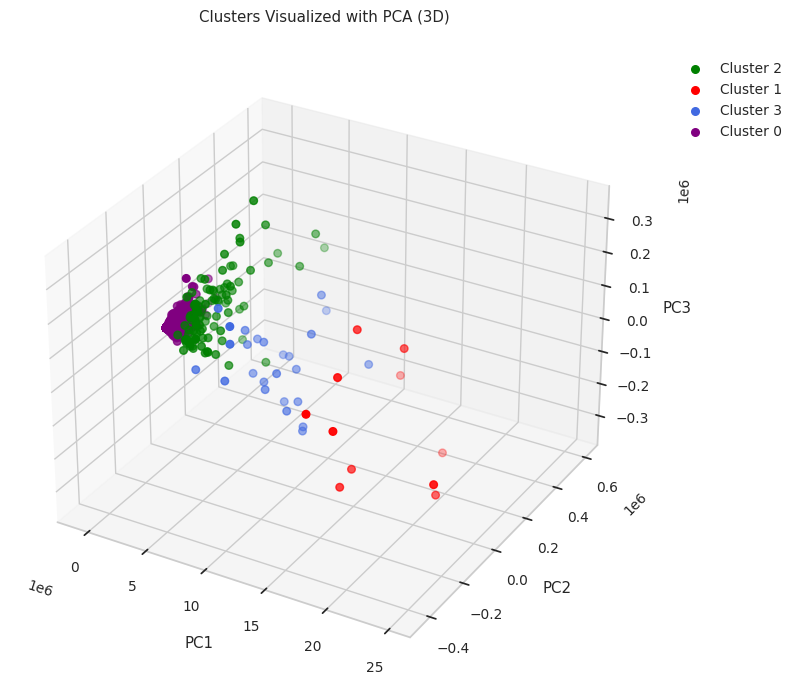

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
result_df = clustered_data[[
    'Total_cons', 'Avg_cons', 'Median_cons', 'std',
    'moving_mean_25', 'moving_mean_50', 'moving_mean_75', 'moving_mean_95', 'moving_mean_100',
    'moving_median_25', 'moving_median_50', 'moving_median_75', 'moving_median_95', 'moving_median_100',
    'expo_25', 'expo_50', 'expo_75', 'expo_95', 'expo_100',
    'lag_25', 'lag_50', 'lag_75', 'lag_95', 'lag_100',
    'winter_25', 'winter_50', 'winter_75', 'winter_100',
    'summer_25', 'summer_50', 'summer_75', 'summer_100',
    'autumn_25', 'autumn_50', 'autumn_75', 'autumn_100',
    'spring_25', 'spring_50', 'spring_75', 'spring_100',
    'p99-p1/p50', 'trimmed_mean', 'mean_abs_dev', 'median_abs_dev', 'mean/peak',
    'trimmed_range', 'range', 'hourly_range', 'daily_range', 'weekly_range',
    'day_of_week_range', 'monthly_range', 'monthly_avg', 'weekly_avg', 'daily_avg', 'hourly_avg',
    'cons_10', 'cons_25', 'cons_50', 'cons_75', 'cons_90', 'cons_95', 'cons_100',
    'hourly_10', 'hourly_25', 'hourly_50', 'hourly_75', 'hourly_90', 'hourly_95', 'hourly_100',
    'daily_10', 'daily_25', 'daily_50', 'daily_75', 'daily_90', 'daily_95', 'daily_100',
    'weekly_10', 'weekly_25', 'weekly_50', 'weekly_75', 'weekly_90', 'weekly_95', 'weekly_100',
    'monthly_10', 'monthly_25', 'monthly_50', 'monthly_75', 'monthly_90', 'monthly_95', 'monthly_100',
    'Cluster_encoded'
]]

temp_df = clustered_data[['Cluster']]
pca = PCA(n_components=3)
df_pca = pca.fit_transform(result_df)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
colors = ['green', 'red', 'royalblue', 'purple', 'pink', 'yellow']
result_df['Cluster'] = temp_df['Cluster']
cluster_labels = result_df['Cluster'].unique()

for i, cluster_label in enumerate(cluster_labels):
    cluster_data = df_pca[result_df['Cluster'] == cluster_label]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
               label=f'Cluster {cluster_label}', color=colors[i], s=30)

ax.set_title('Clusters Visualized with PCA (3D)', pad=20)
ax.set_xlabel('PC1', labelpad=12)
ax.set_ylabel('PC2', labelpad=12)
ax.set_zlabel('PC3', labelpad=12)
ax.ticklabel_format(style='sci', axis='x', scilimits=(6, 6))
ax.ticklabel_format(style='sci', axis='y', scilimits=(6, 6))
ax.ticklabel_format(style='sci', axis='z', scilimits=(6, 6))

ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


Hierarchial Clustering

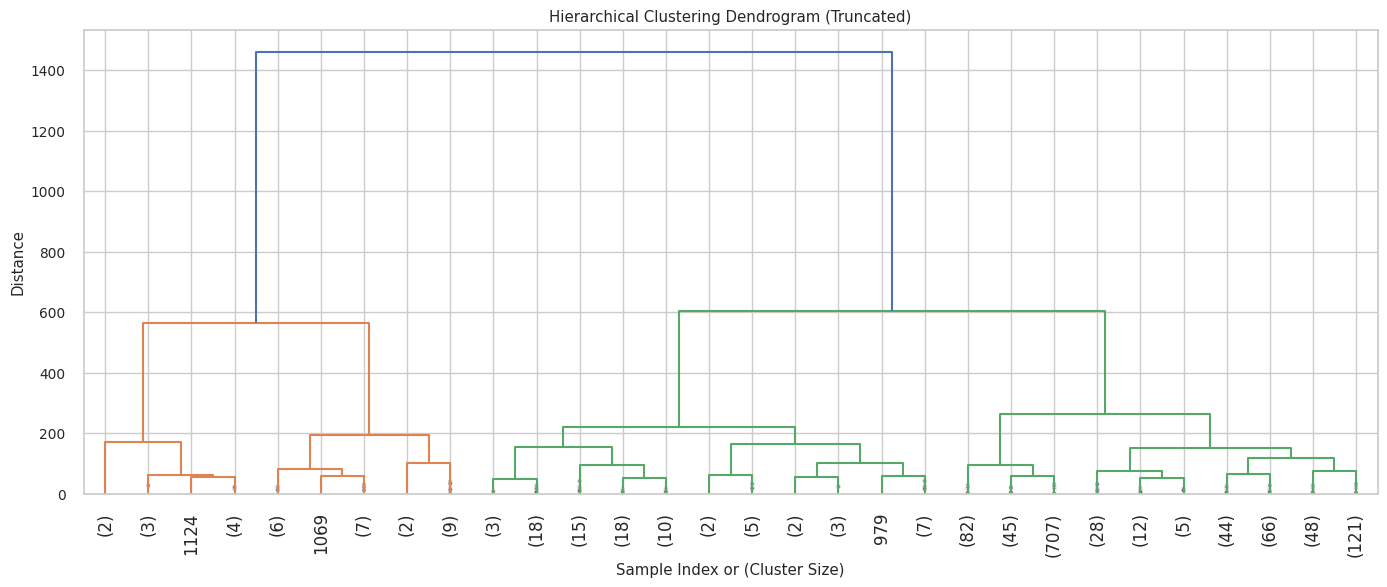

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

features_df_copy = features_df[['Total_cons','Avg_cons','Median_cons','std','moving_mean_25','moving_mean_50','moving_mean_75','moving_mean_95','moving_mean_100','moving_median_25','moving_median_50',
                         'moving_median_75','moving_median_95','moving_median_100','expo_25','expo_50','expo_75','expo_95','expo_100','lag_25','lag_50','lag_75','lag_95','lag_100','winter_25','winter_50',
                         'winter_75','winter_100','summer_25','summer_50','summer_75','summer_100','autumn_25','autumn_50','autumn_75','autumn_100','spring_25','spring_50','spring_75','spring_100','p99-p1/p50',
                         'trimmed_mean','mean_abs_dev','median_abs_dev','mean/peak','trimmed_range','range','hourly_range','daily_range','weekly_range','day_of_week_range','monthly_range','monthly_avg',
                         'weekly_avg','daily_avg','hourly_avg','cons_10','cons_25','cons_50','cons_75','cons_90','cons_95','cons_100','hourly_10','hourly_25','hourly_50','hourly_75','hourly_90','hourly_95','hourly_100',
                         'daily_10','daily_25','daily_50','daily_75','daily_90','daily_95','daily_100','weekly_10','weekly_25','weekly_50','weekly_75','weekly_90','weekly_95','weekly_100','monthly_10','monthly_25','monthly_50',
                         'monthly_75','monthly_90','monthly_95','monthly_100']]
scaler = RobustScaler()
X_scaled = scaler.fit_transform(features_df_copy)
linked = linkage(X_scaled, method='ward')

plt.figure(figsize=(14, 6))
dendrogram(linked, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram (Truncated)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
n_clusters = 4

model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = model.fit_predict(X_scaled)
features_df['HClust_Label'] = cluster_labels

In [ ]:
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for Hierarchical Clustering (k={n_clusters}): {sil_score:.4f}")

Silhouette Score for Hierarchical Clustering (k=4): 0.7645


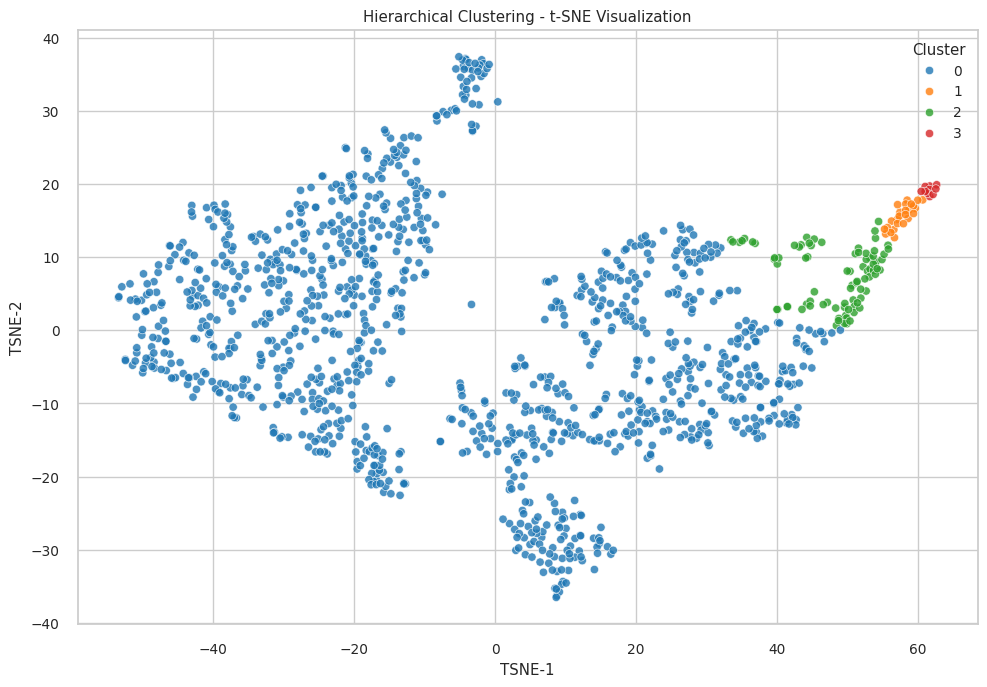

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame()
tsne_df['TSNE-1'] = tsne_result[:, 0]
tsne_df['TSNE-2'] = tsne_result[:, 1]
tsne_df['Cluster'] = cluster_labels
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x='TSNE-1', y='TSNE-2', hue='Cluster', palette='tab10', alpha=0.8)
plt.title('Hierarchical Clustering - t-SNE Visualization')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
import pickle
n_clusters = 4
model = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
cluster_labels = model.fit_predict(features_df_copy)
with open('hclust_model.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('hclust_model.pkl', 'rb') as file:
    model = pickle.load(file)
cluster_labels = model.fit_predict(features_df_copy)
features_df['HClust_Label'] = cluster_labels
n_clusters = len(set(cluster_labels))
print(f"Estimated number of clusters: {n_clusters}")

Estimated number of clusters: 4


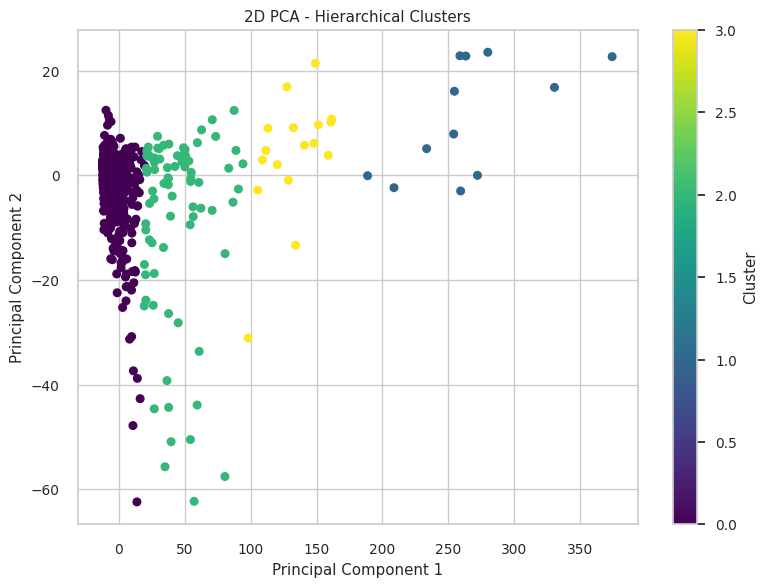

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.scatter(pca_2d_result[:, 0], pca_2d_result[:, 1], c=features_df['HClust_Label'], cmap='viridis', s=30)
plt.title('2D PCA - Hierarchical Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

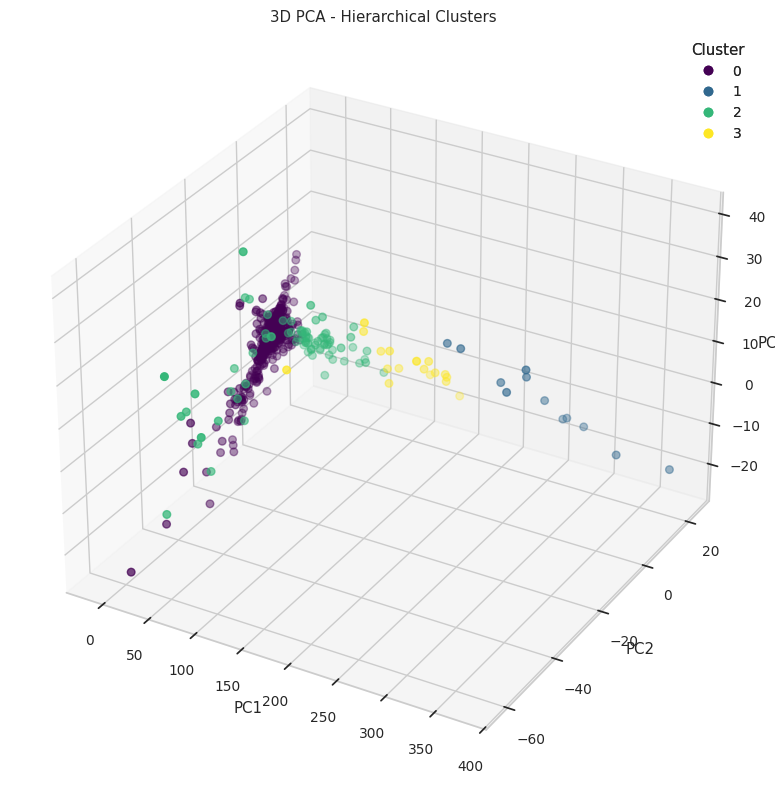

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
pca_3d_result = pca_3d.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    pca_3d_result[:, 0], pca_3d_result[:, 1], pca_3d_result[:, 2],
    c=features_df['HClust_Label'], cmap='viridis', s=30
)
ax.set_title('3D PCA - Hierarchical Clusters')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tqdm import tqdm
TARGET_COL = 'out.electricity.total.energy_consumption'
SEQUENCE_LENGTH = 672
N_CLUSTERS = 6
LATENT_DIM = 128
all_time_series = []

for df in tqdm(building_data):
    df = df.set_index('timestamp')
    df_resampled = df[TARGET_COL].resample('15min').mean().fillna(0)
    if len(df_resampled) >= SEQUENCE_LENGTH:
        ts = df_resampled[-SEQUENCE_LENGTH:].values
    else:
        pad_len = SEQUENCE_LENGTH - len(df_resampled)
        ts = np.pad(df_resampled.values, (pad_len, 0), mode='constant')
    scaler = MinMaxScaler()
    ts_scaled = scaler.fit_transform(ts.reshape(-1, 1)).flatten()
    all_time_series.append(ts_scaled)
X_seq = np.array(all_time_series).reshape(len(all_time_series), SEQUENCE_LENGTH, 1)
input_layer = Input(shape=(SEQUENCE_LENGTH, 1))
encoded = LSTM(LATENT_DIM, return_sequences=False)(input_layer)
encoded = Dropout(0.2)(encoded)
decoded = RepeatVector(SEQUENCE_LENGTH)(encoded)
decoded = LSTM(LATENT_DIM, return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()
autoencoder.fit(X_seq, X_seq, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

encoder = Model(inputs=input_layer, outputs=encoded)
X_latent = encoder.predict(X_seq)
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_latent)
results_df = pd.DataFrame({'Building_ID': np.arange(1, len(cluster_labels) + 1), 'Cluster': cluster_labels})
results_df.head()


100%|██████████| 1277/1277 [00:08<00:00, 154.34it/s]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 672, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 672, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 672, 128)       │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 672, 1)         │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 266s 7s/step - loss: 0.0775 - val_loss: 0.0859
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - loss: 0.0539 - val_loss: 0.0698
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 192s 5s/step - loss: 0.0452 - val_loss: 0.0653
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 205s 5s/step - loss: 0.0443 - val_loss: 0.0661
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - loss: 0.0442 - val_loss: 0.0657
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 163s 5s/step - loss: 0.0446 - val_loss: 0.0641
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 193s 5s/step - loss: 0.0432 - val_loss: 0.0661
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 222s 5s/step - loss: 0.0434 - val_loss: 0.0642
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - loss: 0.0429 - val_loss: 0.0642
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 204s 6s/step - loss: 0.0423 - val_loss: 0.0644
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step


Building_ID  Cluster
0            1        0
1            2        4
2            3        5
3            4        2
4            5        4

Cluster Profiling

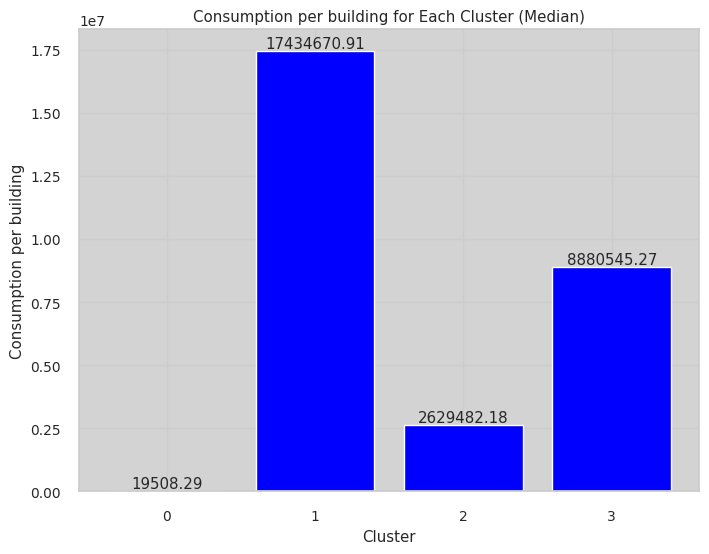

In [ ]:
import matplotlib.pyplot as plt
clustered_data['Cluster'] = clustered_data['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})
total_cons_median = clustered_data.groupby(['Cluster'], as_index=False)[['Total_cons']].median()
total_cons_median['Cluster'] = total_cons_median['Cluster'].astype(str)
plt.figure(figsize=(8, 6))
bars = plt.bar(total_cons_median['Cluster'], total_cons_median['Total_cons'], color='blue')
plt.xlabel('Cluster')
plt.ylabel('Consumption per building')
plt.title('Consumption per building for Each Cluster (Median)')
plt.xticks(total_cons_median['Cluster'])
plt.gca().set_facecolor('lightgrey')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()


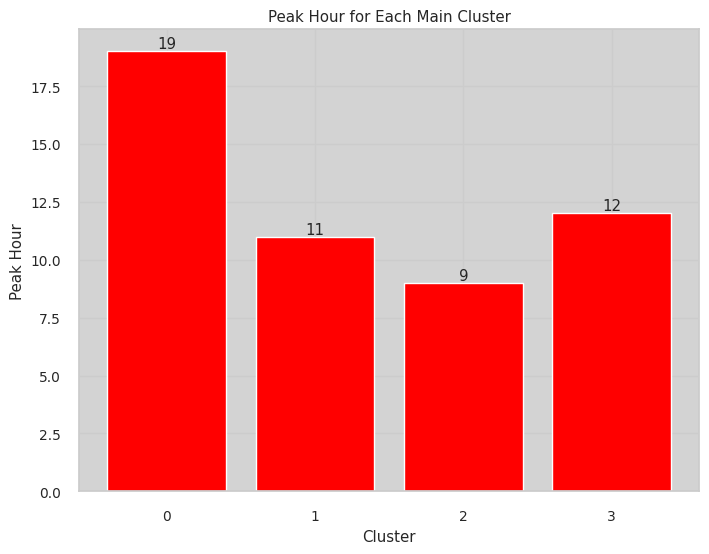

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Merge '0a', '0b', '0c' into '0'
clustered_data['Cluster'] = clustered_data['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})

# Step 2: Define mode extractor
def extract_mode(x):
    mode_value = x.mode().iloc[0] if not x.empty else None
    return mode_value

# Step 3: Group by Cluster and extract mode
hourly_peak_mode = clustered_data.groupby(['Cluster'], as_index=False)[['which_hour_peak']].agg(extract_mode)
hourly_peak_mode['Cluster'] = hourly_peak_mode['Cluster'].astype(str)

# Step 4: Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(hourly_peak_mode['Cluster'], hourly_peak_mode['which_hour_peak'], color='red')
plt.xlabel('Cluster')
plt.ylabel('Peak Hour')
plt.title('Peak Hour for Each Main Cluster')
plt.xticks(hourly_peak_mode['Cluster'])
plt.gca().set_facecolor('lightgrey')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom')

plt.show()


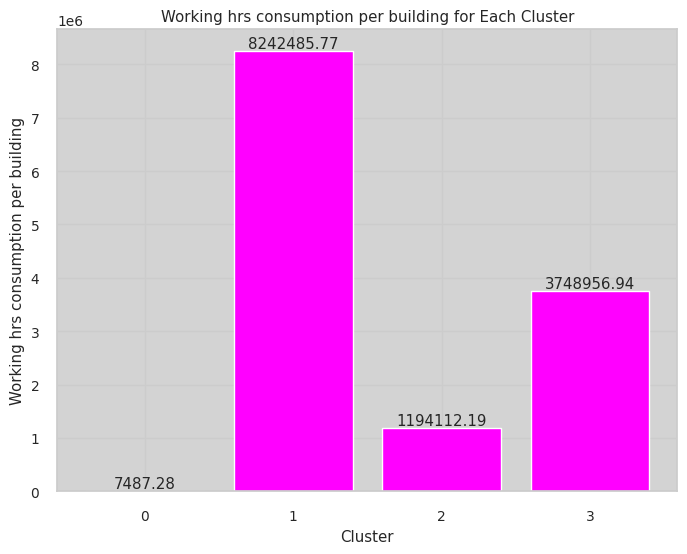

In [ ]:
import matplotlib.pyplot as plt
df = clustered_data.copy()
df['Cluster'] = df['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})

working_hrs_median = df.groupby(['Cluster'], as_index=False)[['Working_hrs_cons']].median()
working_hrs_median = working_hrs_median.round(2)
working_hrs_median['Cluster'] = working_hrs_median['Cluster'].astype(str)

plt.figure(figsize=(8, 6))
bars = plt.bar(working_hrs_median['Cluster'], working_hrs_median['Working_hrs_cons'], color='magenta')
plt.xlabel('Cluster')
plt.ylabel('Working hrs consumption per building')
plt.title('Working hrs consumption per building for Each Cluster')
plt.xticks(working_hrs_median['Cluster'])
plt.gca().set_facecolor('lightgrey')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()


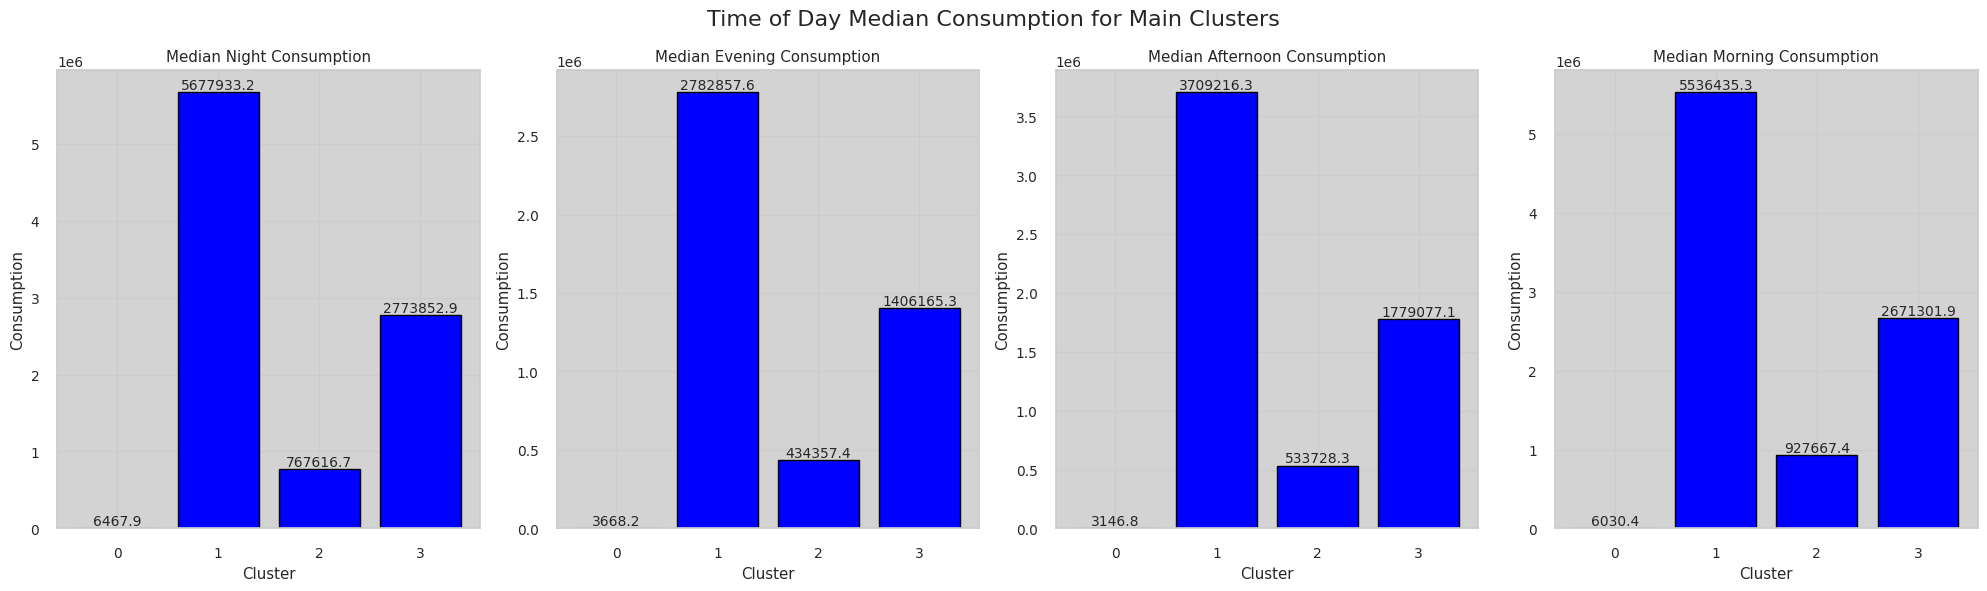

In [ ]:
import matplotlib.pyplot as plt

def plot_time_of_day_consumption(df, title):
    # Step 1: Merge subclusters into main cluster '0'
    df = df.copy()
    df['Cluster'] = df['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})

    # Step 2: Group and calculate medians
    timeofday_clusters = df.groupby(['Cluster'], as_index=False)[['night_cons', 'evening_cons', 'afternoon_cons', 'morning_cons']].median()

    # Step 3: Prepare data
    clusters = timeofday_clusters['Cluster'].astype(str).tolist()
    night_cons = timeofday_clusters['night_cons'].round(1).values
    evening_cons = timeofday_clusters['evening_cons'].round(1).values
    afternoon_cons = timeofday_clusters['afternoon_cons'].round(1).values
    morning_cons = timeofday_clusters['morning_cons'].round(1).values

    # Step 4: Plot
    fig, axs = plt.subplots(1, 4, figsize=(20, 6))
    for i, values, ax in zip(
        ['Night', 'Evening', 'Afternoon', 'Morning'],
        [night_cons, evening_cons, afternoon_cons, morning_cons],
        axs):
        bars = ax.bar(clusters, values, color='blue', edgecolor='black')
        ax.set_xlabel('Cluster')
        ax.set_title(f'Median {i} Consumption')
        ax.set_ylabel('Consumption')
        ax.set_facecolor('lightgrey')
        for bar, val in zip(bars, values):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{val}',
                     ha='center', va='bottom', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function with merged clusters
plot_time_of_day_consumption(clustered_data, 'Time of Day Median Consumption for Main Clusters')


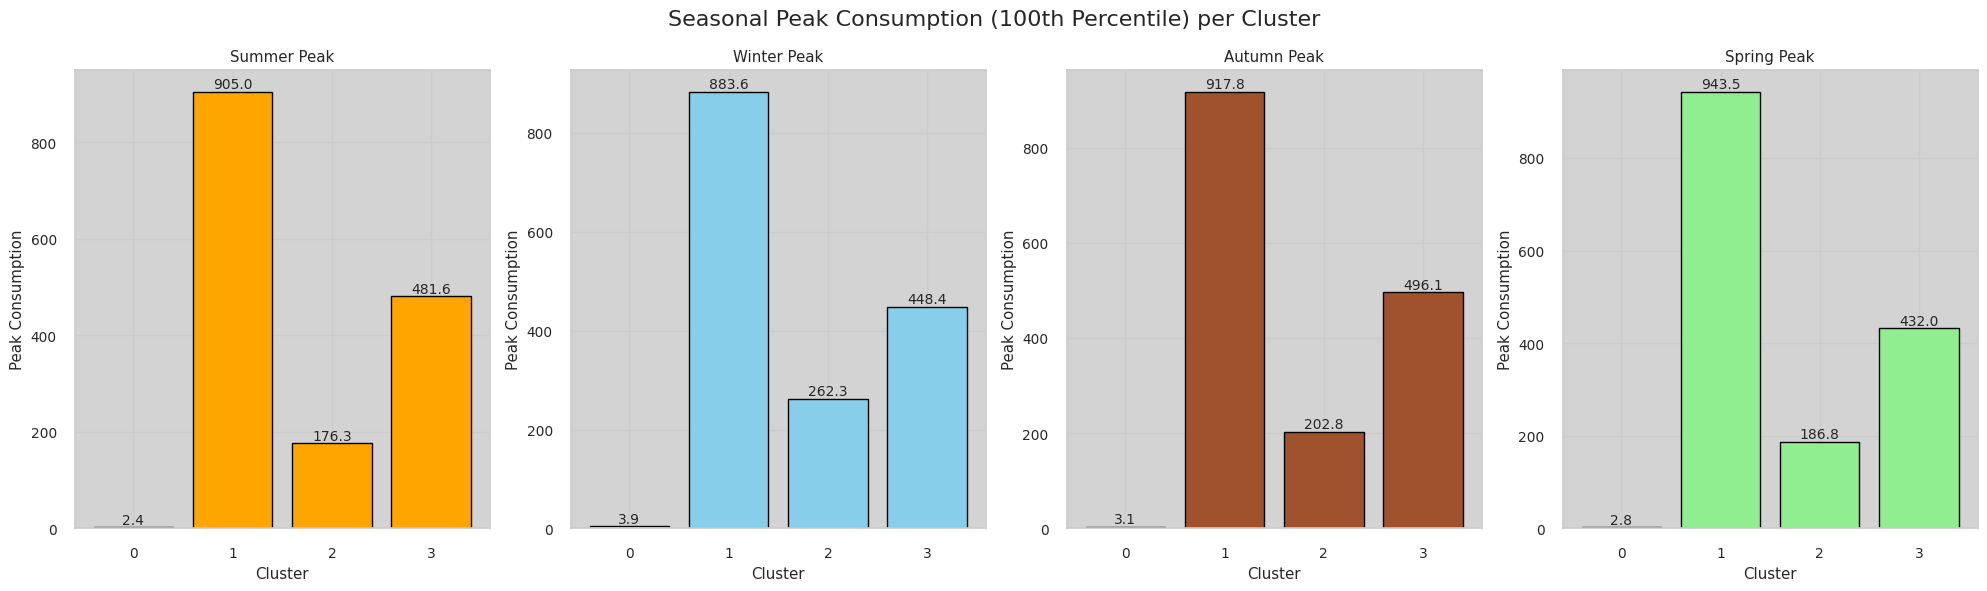

In [ ]:
import matplotlib.pyplot as plt

df = clustered_data.copy()
df['Cluster'] = df['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})

seasonal_peaks = df.groupby('Cluster', as_index=False)[['summer_100', 'winter_100', 'autumn_100', 'spring_100']].median()
seasonal_peaks = seasonal_peaks.round(2)

clusters = seasonal_peaks['Cluster'].astype(str)
colors = ['orange', 'skyblue', 'sienna', 'lightgreen']
seasons = ['summer_100', 'winter_100', 'autumn_100', 'spring_100']
titles = ['Summer Peak', 'Winter Peak', 'Autumn Peak', 'Spring Peak']

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
for i, (season, color, title) in enumerate(zip(seasons, colors, titles)):
    values = seasonal_peaks[season].values
    bars = axs[i].bar(clusters, values, color=color, edgecolor='black')
    axs[i].set_xlabel('Cluster')
    axs[i].set_title(title)
    axs[i].set_ylabel('Peak Consumption')
    axs[i].set_facecolor('lightgrey')
    for bar, val in zip(bars, values):
        axs[i].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{val:.1f}',
                    ha='center', va='bottom', fontsize=10)

plt.suptitle('Seasonal Peak Consumption (100th Percentile) per Cluster', fontsize=16)
plt.tight_layout()
plt.show()


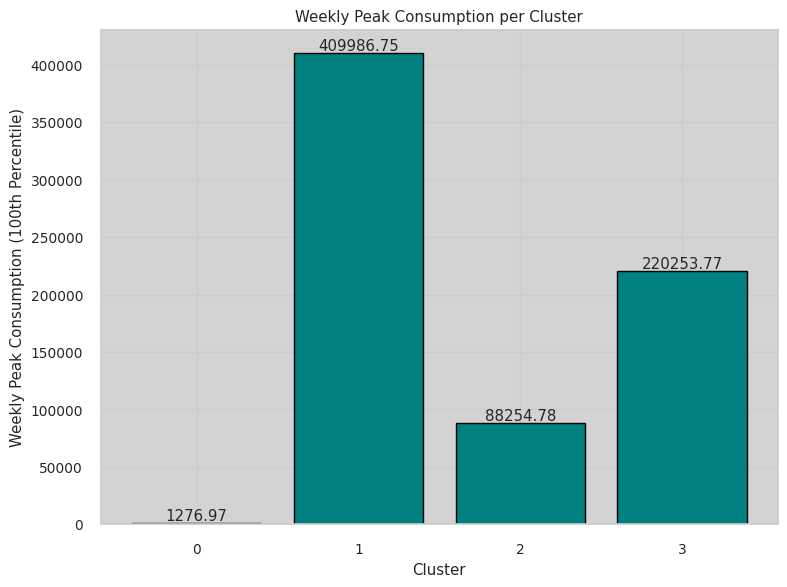

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Merge '0a', '0b', '0c' into '0'
df = clustered_data.copy()
df['Cluster'] = df['Cluster'].replace({'0a': '0', '0b': '0', '0c': '0'})

# Step 2: Compute median of weekly peak consumption
weekly_peak = df.groupby(['Cluster'], as_index=False)[['weekly_100']].median()
weekly_peak = weekly_peak.round(2)
weekly_peak['Cluster'] = weekly_peak['Cluster'].astype(str)

# Step 3: Plot
plt.figure(figsize=(8, 6))
bars = plt.bar(weekly_peak['Cluster'], weekly_peak['weekly_100'], color='teal', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Weekly Peak Consumption (100th Percentile)')
plt.title('Weekly Peak Consumption per Cluster')
plt.xticks(weekly_peak['Cluster'])
plt.gca().set_facecolor('lightgrey')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


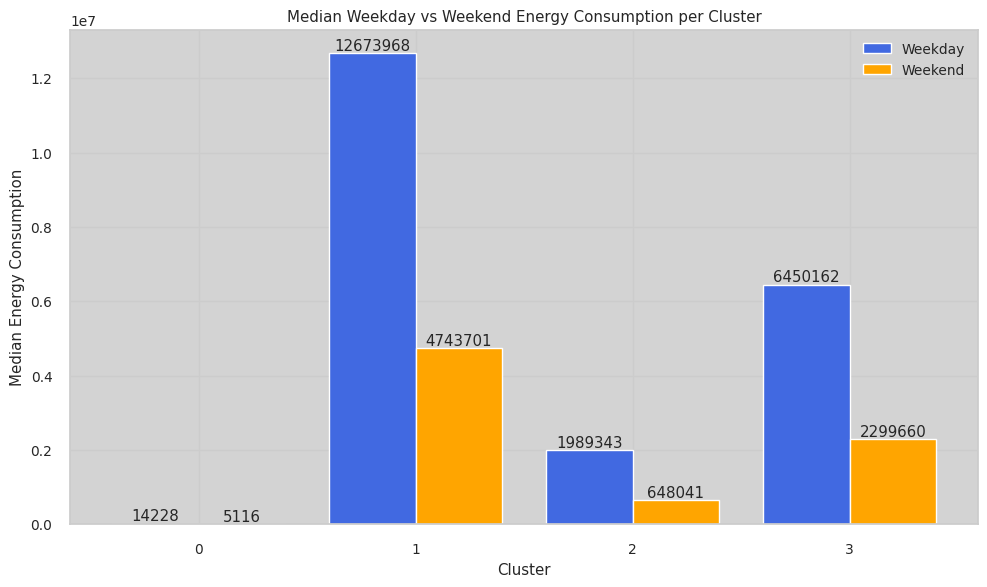

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert relevant columns to numeric
cols_to_convert = ['Cluster', 'weekday_sum', 'weekend_sum']
for col in cols_to_convert:
    clustered_data[col] = pd.to_numeric(clustered_data[col], errors='coerce')

# Group by Cluster and compute median weekday and weekend consumption
week_data = clustered_data.groupby('Cluster', as_index=False)[['weekday_sum', 'weekend_sum']].median()
week_data = week_data.round(2)

# Plotting: Side-by-side bars
plt.figure(figsize=(10, 6))

# Weekday bars
bars1 = plt.bar(week_data['Cluster'] - 0.2, week_data['weekday_sum'], width=0.4, label='Weekday', color='royalblue')

# Weekend bars
bars2 = plt.bar(week_data['Cluster'] + 0.2, week_data['weekend_sum'], width=0.4, label='Weekend', color='orange')

# Axis labels and title
plt.xlabel('Cluster')
plt.ylabel('Median Energy Consumption')
plt.title('Median Weekday vs Weekend Energy Consumption per Cluster')
plt.xticks(week_data['Cluster'])
plt.gca().set_facecolor('lightgrey')
plt.legend()

# Annotate bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()